# ECON 570: Final Project

# Evaluation of Job Training Program with Nonexperimental Data

Masashi Yoshioka (3200-3439-52), Jincen Jiang (6650-5721-72), Shuxian Mao (6221-2815-32)

May 6, 2022

In [1]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Import basic functions
import numpy as np
import pandas as pd
import pyreadr
import random

# Import helper functions
from utils.functions import *

# Set random seeds
np.random.seed(570)
random.seed(570)

# Show enough rows and columns
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)

## 1. Introduction

### 1.1 Research Question

In this project, we will try to evaluate the job training program called the National Supported Work (NSW) Demonstration, which was implemented around the United States in 1970s. In particular, we will examine whether we can replicate experimental estimates of average treatment effect (ATE) and/or average treatment effect on treated (ATET) with nonexperimental data.  

In short, our research question can be specified as: ***Could we obtain reliable ATE and/or ATET estimates of the NSW on earnings with nonexperimental data?***

### 1.2 Literature Review

There has been a huge discussion about whether we can estimate treatment effect with nonexperimental data. The answer still remains to be seen.  

The nonexperimental estimation of the causal effect of the NSW was first introduced by LaLonde (1986). He used data from randomized experiments conducted as a part of the NSW (the details will be explained in 2.1) and investigated the extent to which nonexperimental ATE estimates of the NSW can replicate experimental ones. He first obtained experimental ATE estimates from the randomized experiments by, for example, taking a difference in post-treatment earnings between treatment and control groups, which would be an unbiased estimate for ATE as long as the experiments were truly randomized. Then, he compared the results with the estimates from nonexperimental data (namely, CPS and PSID) obtained through several econometric methods. He failed to replicate the experimental estimates with nonexperimental data and concluded that the standard nonexperimental estimation methods are inaccurate relative to experimental benchmarks and sensitive to the modeling specifications.  

On the other hand, Dehejia and Wahba (1999, 2002) applied propensity score methods to the same dataset as LaLonde (1986) and concluded that they could successfully obtain nonexprimental ATET estimates that were close to experimental benchmarks. They claimed that although propensity score methods cannot account for important unobservables if any, it is still worth exploring the information contained in the observable covariates first, and propensity score matching methods can reduce the bias due to systematic differences between treatment and control groups.

However, Smith and Todd (2005) pointed out that Dehejia and Wahba (1999, 2002) had excluded some samples from the original dataset of LaLonde (1986), which should have made it easier to estimate ATET with nonexperimental data. They applied to the original dataset of LaLonde (1986) the same propensity score matching method that Dehejia and Wahba (1999, 2002) had used, and discovered that the estimates were very sensitive to the choice of variables used in the propensity score estimation and the choice of samples of analysis. They concluded that the propensity score matching would not represent a general solution to causal inferences whereas it is potentially a useful tool.

### 1.3 Why Our Research Question Matters?

We will try to contribute to the above discussion by applying causal inference methods that we have learned in class. Our research question is extremely important from the empirical perspective because experimental data are rarely available in economics and we often need to rely on nonexperimental data to evaluate causal effect of a program. Finding a causal relationship from nonexperimental data is one of the most important tasks of econometrics, but unfortunately, econometrics might not provide a correct estimation of treatment effect if the arguments of LaLonde (1986) and Smith and Todd (2005) hold true in general.

### 1.4 Research Description

To answer our research question, we will use the dataset of LaLonde (1986) and apply a variety of methods to estimate ATE and ATET of the NSW on earnings. We will first apply regression methods. Then, we will use different estimation methods that rely on propensity score, namely propensity score matching, Inverse Probability of Treatment Weighting (IPTW) estimator and doubly robust estimator. In addition to logistic regression that Dehejia and Wahba (1999, 2002) used to estimate the propensity score, we will also use Random Forest and Gradient Boosting in order to examine whether machine learning approaches can improve the propensity score estimation. We will use both the original data of LaLonde (1986) and its subset selected by Dehejia and Wahba (1999, 2002) to see if the criticism by Smith and Todd (2005) holds true.  

The rest of the notebook is organized as follows. Section 2 describes the data that we use along with some background of the NSW. Section 3 applies various methods (regression, propensity score matching, IPTW estimator and doubly robust estimator) and obtains ATE and ATET estimates. Section 4 compares the nonexperimental results with experimental benchmarks and analyzes what we have found. Section 5 concludes and suggests future work.

## 2. Data

### 2.1 The National Supported Work (NSW) Demonstration

We use a dataset from the NSW Demonstration, which has been commonly used in the causal inference literature, including LaLonde (1986), Dehejia and Wahba (1999, 2002) and Smith and Todd (2005) as explained above. 

The NSW was a job training program conducted in the mid-1970s at 15 sites around the U.S. Our dataset is focused on the program implemented in 10 sites from April 1975 to August 1977 in particular. The program was targeted at 4 types of hard-to-employ people: female long-term AFDC<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1) recipients, ex-drug addicts, ex-climinal offenders and high school dropouts. The potential participants had to satisfy a set of eligibility criteria that included: i) they must have been currently unemployed, ii) they must have spent no more than 3 months on one regular job of at least 20 hours per week during the preceding 6 months, and so forth. These criteria as well as self-selection made the participants in the NSW essentially differ from the U.S. population in many characteristics.

The program operated as a randomized experiment by randomly assigning some applicants to a control group that was not allowed to participate in the program. For those assigned to the treatment group, the program guaranteed a job for 9 to 18 months, depending on the target group and site. The program paid the treatment group for their work, but the offered wage was lower than they would have received on a regular job. The participants were forced to find a regular job after their terms in the program expired.

The treatment and control groups were interviewed 5 times in total, one of which was a baseline and the others were follow-ups. Many people failed to complete these interviews and thus the sample attrition could have possibly caused biases. However, LaLonde (1986) suggests that the largest source of attrition, which was supposedly the interview schedule, should not have affected the integrity of the experimental design because the interviews were randomly scheduled. Here we just assume that LaLonde (1986) is right and will not deal with the potential sample attrition problem. The interviews provide information on demographic characteristics, employment history, household income and so forth.

We are interested in the causal effect of the NSW on earnings of participants. Since the program randomly assigned applicants to treatment and control groups, the experimental data would give us an unbiased ATE estimate of the program. LaLonde (1986) compared the experimental data with nonexperimental data such as Current Population Survey (CPS) and Panel Study of Income Dynamics (PSID), concluding that the nonexperimental data fail to generate similar results to those of experimental data. Dehejia and Wahba (1999, 2002) concentrated on subsamples whose earnings in 1974 were available, and concluded that propensity score matching could generate the results close to experimental ones. Since we use both data of LaLonde (1986) and those of Dehejia and Wahba (1999, 2002), our dataset consists of 6 different groups of samples: experimental treatment group of LaLonde (1986), experimental control group of LaLonde (1986), experimental treatment subgroup of Dehejia and Wahba (1999, 2002), experimental control subgroup of Dehejia and Wahba (1999, 2002), nonexperimental data from CPS, and nonexperimental data from PSID. Using the dataset, we will see if nonexperimental data can generate estimates that are close enough to experimental results.

### 2.2 Sampling Restrictions

The datasets were retrieved from https://github.com/jjchern/lalonde/tree/master/data on February 2, 2022. Note that it only includes male samples due to the data availability of LaLonde (1986) whereas LaLonde (1986) analyzed female samples as well. Dehejia and Wahba (1999, 2002) and Smith and Todd (2005) focused on males for the same reason.

This repository also includes subsamples of CPS and PSID that were chosen by LaLonde (1986), attempting to make them resemble the NSW applicants. However, Dehejia and Wahba (1999, 2002) argued that choosing subsamples arbitrarily from the nonexperimental data would not improve the estimates. Smith and Todd (2005) also ignored these subsamples. Thus, we have decided to use 6 groups described in 2.1 and discard subsamples of CPS and PSID. For the same reason, we do not do any sampling restrictions including outlier removal in order to avoid the potential bias from arbitrary selection of subsamples. Since the experiment was randomized, using all the experimental samples would give an unbiased estimate of ATE. On the other hand, arbitrary sample restrictions can make treatment and control groups incomparable, which could cause a bias in the estimate even if the experiments were randomized.  

We will trim some samples when using propensity score, but it will be determined mechanically based on the estimated values of the propensity score. We do not discard any samples before starting estimation.

### 2.3 Summary Statistics

First of all, we describe the summary statistics of each group below. The data includes the treatment status (`treat`), age (`age`), years of education (`education`), dummy for black (`black`), dummy for hispanic (`hispanic`), dummy for being married (`married`), dummy for high school dropout (`nodegree`), earnings in 1975 (`re75`) and those in 1978 (`re78`). Note that the earnings in 1974 (`re74`) are only available for Dehejia and Wahba (1999, 2002) subsamples but not for LaLonde (1986) samples.  

Henceforth, the original experimental data of LaLonde (1986) and its subsamples selected by Dehejia and Wahba (1999, 2002) will be simply called "LaLonde dataset" and "DW subset", respectively, for the sake of brevity.

#### 2.3.1 LaLonde (1986) Experimental Data

First, we show the distributions of variables of LaLonde dataset. In particular, we compare the distributions of treated and controlled groups to see if they are truly comparable.

In [2]:
# Read LaLonde dataset
df_nsw = pyreadr.read_r('./data/nsw.rda')['nsw']
df_nsw.head()

data_id  treat   age  education  black  hispanic  married  nodegree  \
0  Lalonde Sample    1.0  37.0       11.0    1.0       0.0      1.0       1.0   
1  Lalonde Sample    1.0  22.0        9.0    0.0       1.0      0.0       1.0   
2  Lalonde Sample    1.0  30.0       12.0    1.0       0.0      0.0       0.0   
3  Lalonde Sample    1.0  27.0       11.0    1.0       0.0      0.0       1.0   
4  Lalonde Sample    1.0  33.0        8.0    1.0       0.0      0.0       1.0   

   re75          re78  
0   0.0   9930.045898  
1   0.0   3595.894043  
2   0.0  24909.449219  
3   0.0   7506.145996  
4   0.0    289.789886

In [3]:
# Summarize the variables of treatment group of LaLonde dataset
print('Treatment Group of LaLonde Dataset')
df_nsw[df_nsw['treat'] == 1].describe().T

Treatment Group of LaLonde Dataset


count         mean          std   min         25%          50%  \
treat      297.0     1.000000     0.000000   1.0    1.000000     1.000000   
age        297.0    24.626263     6.686391  17.0   20.000000    23.000000   
education  297.0    10.380471     1.817712   4.0    9.000000    11.000000   
black      297.0     0.801347     0.399660   0.0    1.000000     1.000000   
hispanic   297.0     0.094276     0.292706   0.0    0.000000     0.000000   
married    297.0     0.168350     0.374808   0.0    0.000000     0.000000   
nodegree   297.0     0.730640     0.444376   0.0    0.000000     1.000000   
re75       297.0  3066.098191  4874.888996   0.0    0.000000  1117.438965   
re78       297.0  5976.352024  6923.796406   0.0  549.298401  4232.309082   

                   75%           max  
treat         1.000000      1.000000  
age          27.000000     49.000000  
education    12.000000     16.000000  
black         1.000000      1.000000  
hispanic      0.000000      1.000000  
married       0.000000      1.000000  
nodegree      1.000000      1.000000  
re75       4310.455078  37431.660156  
re78       9381.294922  60307.929688

In [4]:
# Summarize the variables of control group of LaLonde dataset
print('Control Group of LaLonde Dataset')
df_nsw[df_nsw['treat'] == 0].describe().T

Control Group of LaLonde Dataset


count         mean          std   min   25%          50%  \
treat      425.0     0.000000     0.000000   0.0   0.0     0.000000   
age        425.0    24.447059     6.590276  17.0  19.0    23.000000   
education  425.0    10.188235     1.618686   3.0   9.0    10.000000   
black      425.0     0.800000     0.400471   0.0   1.0     1.000000   
hispanic   425.0     0.112941     0.316894   0.0   0.0     0.000000   
married    425.0     0.157647     0.364839   0.0   0.0     0.000000   
nodegree   425.0     0.814118     0.389470   0.0   1.0     1.000000   
re75       425.0  3026.682756  5201.249820   0.0   0.0   823.254395   
re78       425.0  5090.048301  5718.088763   0.0   0.0  3746.700928   

                   75%           max  
treat         0.000000      0.000000  
age          28.000000     55.000000  
education    11.000000     14.000000  
black         1.000000      1.000000  
hispanic      0.000000      1.000000  
married       0.000000      1.000000  
nodegree      1.000000      1.000000  
re75       3649.769043  36941.269531  
re78       8329.823242  39483.531250

The above tables describe the variables of treatment and control groups of LaLonde dataset. We can see that the characteristics of treatment and control groups are quite similar to each other except `re78`, which is an outcome of the program. Every pre-treatment variable has a similar mean, standard deviation and so forth.  

If the experiments were truly randomized, treatment and control groups should be comparable in any pre-treatment variable. The above statistics are consistent with the randomized design of the NSW.

#### 2.3.2 Dehejia and Wahba (1999, 2002) Experimental Data

Then, we compare treatment and control groups of DW subset.

In [5]:
# Read DW subset
df_nsw_dw = pyreadr.read_r('./data/nsw_dw.rda')['nsw_dw']
df_nsw_dw.head()

data_id  treat   age  education  black  hispanic  married  \
0  Dehejia-Wahba Sample    1.0  37.0       11.0    1.0       0.0      1.0   
1  Dehejia-Wahba Sample    1.0  22.0        9.0    0.0       1.0      0.0   
2  Dehejia-Wahba Sample    1.0  30.0       12.0    1.0       0.0      0.0   
3  Dehejia-Wahba Sample    1.0  27.0       11.0    1.0       0.0      0.0   
4  Dehejia-Wahba Sample    1.0  33.0        8.0    1.0       0.0      0.0   

   nodegree  re74  re75          re78  
0       1.0   0.0   0.0   9930.045898  
1       1.0   0.0   0.0   3595.894043  
2       0.0   0.0   0.0  24909.449219  
3       1.0   0.0   0.0   7506.145996  
4       1.0   0.0   0.0    289.789886

In [6]:
# Summarize the variables of treatment group of DW subset
print('Treatment Group of DW subset')
df_nsw_dw[df_nsw_dw['treat'] == 1].describe().T

Treatment Group of DW subset


count         mean          std   min         25%          50%  \
treat      185.0     1.000000     0.000000   1.0    1.000000     1.000000   
age        185.0    25.816216     7.155019  17.0   20.000000    25.000000   
education  185.0    10.345946     2.010650   4.0    9.000000    11.000000   
black      185.0     0.843243     0.364558   0.0    1.000000     1.000000   
hispanic   185.0     0.059459     0.237124   0.0    0.000000     0.000000   
married    185.0     0.189189     0.392722   0.0    0.000000     0.000000   
nodegree   185.0     0.708108     0.455867   0.0    0.000000     1.000000   
re74       185.0  2095.573693  4886.620354   0.0    0.000000     0.000000   
re75       185.0  1532.055313  3219.250879   0.0    0.000000     0.000000   
re78       185.0  6349.143502  7867.402183   0.0  485.229797  4232.309082   

                   75%           max  
treat         1.000000      1.000000  
age          29.000000     48.000000  
education    12.000000     16.000000  
black         1.000000      1.000000  
hispanic      0.000000      1.000000  
married       0.000000      1.000000  
nodegree      1.000000      1.000000  
re74       1291.468018  35040.070312  
re75       1817.284058  25142.240234  
re78       9642.999023  60307.929688

In [7]:
# Summarize the variables of control group of DW subset
print('Control Group of DW subset')
df_nsw_dw[df_nsw_dw['treat'] == 0].describe().T

Control Group of DW subset


count         mean          std   min   25%          50%  \
treat      260.0     0.000000     0.000000   0.0   0.0     0.000000   
age        260.0    25.053846     7.057745  17.0  19.0    24.000000   
education  260.0    10.088462     1.614325   3.0   9.0    10.000000   
black      260.0     0.826923     0.379043   0.0   1.0     1.000000   
hispanic   260.0     0.107692     0.310589   0.0   0.0     0.000000   
married    260.0     0.153846     0.361497   0.0   0.0     0.000000   
nodegree   260.0     0.834615     0.372244   0.0   1.0     1.000000   
re74       260.0  2107.026651  5687.905639   0.0   0.0     0.000000   
re75       260.0  1266.909015  3102.982088   0.0   0.0     0.000000   
re78       260.0  4554.801120  5483.836001   0.0   0.0  3138.795532   

                   75%           max  
treat         0.000000      0.000000  
age          28.000000     55.000000  
education    11.000000     14.000000  
black         1.000000      1.000000  
hispanic      0.000000      1.000000  
married       0.000000      1.000000  
nodegree      1.000000      1.000000  
re74        139.424698  39570.679688  
re75        650.096451  23031.980469  
re78       7288.420044  39483.531250

Compared to LaLonde dataset, some of the variables appear to show different distributions between treatment and control groups in DW subsets. For instance, earnings in 1975 (`re75`) of treatment group are higher than those of control group, although the difference does not appear to be statistically significant. By choosing only the subsamples whose earnings in 1974 were available, Dehejia and Wahba (1999, 2002) might have distorted the samples and hurt the comparability between treatment and control groups.

#### 2.3.3 Nonexperimental Data (CPS and PSID)

Now we will see how differently distributed are the variables of two nonexperimental data, CPS and PSID, from experimental data of LaLonde and DW.

In [8]:
# Read CPS data
df_cps = pyreadr.read_r('./data/cps_controls.rda')['cps_controls']
df_cps.head()

data_id  treat   age  education  black  hispanic  married  nodegree  \
0    CPS1    0.0  45.0       11.0    0.0       0.0      1.0       1.0   
1    CPS1    0.0  21.0       14.0    0.0       0.0      0.0       0.0   
2    CPS1    0.0  38.0       12.0    0.0       0.0      1.0       0.0   
3    CPS1    0.0  48.0        6.0    0.0       0.0      1.0       1.0   
4    CPS1    0.0  18.0        8.0    0.0       0.0      1.0       1.0   

           re74          re75          re78  
0  21516.669922  25243.550781  25564.669922  
1   3175.970947   5852.564941  13496.080078  
2  23039.019531  25130.759766  25564.669922  
3  24994.369141  25243.550781  25564.669922  
4   1669.295044  10727.610352   9860.869141

In [9]:
# Summarize the variables of CPS
print('CPS')
df_cps.describe().T

CPS


count          mean          std   min          25%  \
treat      15992.0      0.000000     0.000000   0.0     0.000000   
age        15992.0     33.225238    11.045216  16.0    24.000000   
education  15992.0     12.027514     2.870846   0.0    11.000000   
black      15992.0      0.073537     0.261024   0.0     0.000000   
hispanic   15992.0      0.072036     0.258556   0.0     0.000000   
married    15992.0      0.711731     0.452971   0.0     0.000000   
nodegree   15992.0      0.295835     0.456432   0.0     0.000000   
re74       15992.0  14016.800360  9569.795964   0.0  4403.452393   
re75       15992.0  13650.803522  9270.403408   0.0  4398.823242   
re78       15992.0  14846.659650  9647.391501   0.0  5669.298096   

                    50%           75%           max  
treat          0.000000      0.000000      0.000000  
age           31.000000     42.000000     55.000000  
education     12.000000     13.000000     18.000000  
black          0.000000      0.000000      1.000000  
hispanic       0.000000      0.000000      1.000000  
married        1.000000      1.000000      1.000000  
nodegree       0.000000      1.000000      1.000000  
re74       15123.580078  23584.179688  25862.320312  
re75       14557.110352  22923.736816  25243.550781  
re78       16421.974609  25564.669922  25564.669922

In [10]:
# Read PSID data
df_psid = pyreadr.read_r('./data/psid_controls.rda')['psid_controls']
df_psid.head()

data_id  treat   age  education  black  hispanic  married  nodegree  re74  \
0    PSID    0.0  47.0       12.0    0.0       0.0      0.0       0.0   0.0   
1    PSID    0.0  50.0       12.0    1.0       0.0      1.0       0.0   0.0   
2    PSID    0.0  44.0       12.0    0.0       0.0      0.0       0.0   0.0   
3    PSID    0.0  28.0       12.0    1.0       0.0      1.0       0.0   0.0   
4    PSID    0.0  54.0       12.0    0.0       0.0      1.0       0.0   0.0   

   re75  re78  
0   0.0   0.0  
1   0.0   0.0  
2   0.0   0.0  
3   0.0   0.0  
4   0.0   0.0

In [11]:
# Summarize the variables of PSID
print('PSID')
df_psid.describe().T

PSID


count          mean           std   min           25%  \
treat      2490.0      0.000000      0.000000   0.0      0.000000   
age        2490.0     34.850602     10.440757  18.0     26.000000   
education  2490.0     12.116867      3.082435   0.0     11.000000   
black      2490.0      0.250602      0.433447   0.0      0.000000   
hispanic   2490.0      0.032530      0.177439   0.0      0.000000   
married    2490.0      0.866265      0.340436   0.0      1.000000   
nodegree   2490.0      0.305221      0.460593   0.0      0.000000   
re74       2490.0  19428.745805  13406.877171   0.0  10775.966797   
re75       2490.0  19063.337668  13596.954865   0.0   9846.774414   
re78       2490.0  21553.920924  15555.345539   0.0  11526.266602   

                    50%           75%            max  
treat          0.000000      0.000000       0.000000  
age           33.000000     44.000000      55.000000  
education     12.000000     14.000000      17.000000  
black          0.000000      1.000000       1.000000  
hispanic       0.000000      0.000000       1.000000  
married        1.000000      1.000000       1.000000  
nodegree       0.000000      1.000000       1.000000  
re74       18417.107422  26450.101562  137148.687500  
re75       17903.226562  26496.773438  156653.234375  
re78       20688.171875  29554.531250  121173.578125

The above statistics obviously show that neither CPS nor PSID samples are comparable with LaLonde dataset or DW subset. For instance, samples in CPS and PSID are 33 and 35 years old on average, respecively, whereas the average age of LaLonde dataset and DW subset are about 25&ndash;26 whether or not they are treated. We will show the distributional differences graphically below.  

Before that, we append all the datasets for convenience.

In [12]:
# Combine all of the datasets to get the base data
df_nsw.loc[df_nsw['treat'] == 1, 'data_id'] = 'LT'
df_nsw.loc[df_nsw['treat'] == 0, 'data_id'] = 'LC'
df_nsw_dw.loc[df_nsw_dw['treat'] == 1, 'data_id'] = 'DWT'
df_nsw_dw.loc[df_nsw_dw['treat'] == 0, 'data_id'] = 'DWC'
df_cps.data_id = 'CPS'

df = pd.concat([df_nsw, df_nsw_dw, df_cps, df_psid]).reset_index(drop = True)
df.data_id = pd.Categorical(df.data_id, ['LT', 'LC', 'DWT', 'DWC', 'CPS', 'PSID'])
df.head()

data_id  treat   age  education  black  hispanic  married  nodegree  re75  \
0      LT    1.0  37.0       11.0    1.0       0.0      1.0       1.0   0.0   
1      LT    1.0  22.0        9.0    0.0       1.0      0.0       1.0   0.0   
2      LT    1.0  30.0       12.0    1.0       0.0      0.0       0.0   0.0   
3      LT    1.0  27.0       11.0    1.0       0.0      0.0       1.0   0.0   
4      LT    1.0  33.0        8.0    1.0       0.0      0.0       1.0   0.0   

           re78  re74  
0   9930.045898   NaN  
1   3595.894043   NaN  
2  24909.449219   NaN  
3   7506.145996   NaN  
4    289.789886   NaN

The resulting data frame `df` works as a base data throughout our project. The column `data_id` represents the 6 groups that we have defined, i.e., LaLonde experimental treatment (`'LT'`), LaLonde experimental control (`'LC'`), DW experimental treatment (`'DWT'`), DW experimental control (`'DWC'`), CPS nonexperimental control (`'CPS'`) and PSID nonexperimental control (`'PSID'`).  
  
We do not transform variables except for linear regression models, where we will use the squared values of `age` as one of the covariates following LaLonde (1986). Random Forest and Gradient Boosting will be able to fit to nonlinear relationships without transforming variables manually, so we have decided to keep the variables as they are basically.  
  
We define a varaible `dif` which represents the difference between earnings in 1978 and 1975, i.e., `re78` minus `re75`. We will use both `dif` and `re78` as our dependent variables.

In [13]:
# Add a difference in earnings between 1978 and 1975
df['dif'] = df['re78'] - df['re75']
df

data_id  treat   age  education  black  hispanic  married  nodegree  \
0          LT    1.0  37.0       11.0    1.0       0.0      1.0       1.0   
1          LT    1.0  22.0        9.0    0.0       1.0      0.0       1.0   
2          LT    1.0  30.0       12.0    1.0       0.0      0.0       0.0   
3          LT    1.0  27.0       11.0    1.0       0.0      0.0       1.0   
4          LT    1.0  33.0        8.0    1.0       0.0      0.0       1.0   
...       ...    ...   ...        ...    ...       ...      ...       ...   
19644    PSID    0.0  47.0        8.0    0.0       0.0      1.0       1.0   
19645    PSID    0.0  32.0        8.0    0.0       0.0      1.0       1.0   
19646    PSID    0.0  47.0       10.0    0.0       0.0      1.0       1.0   
19647    PSID    0.0  54.0        0.0    0.0       1.0      1.0       1.0   
19648    PSID    0.0  40.0        8.0    0.0       0.0      1.0       1.0   

               re75          re78          re74           dif  
0          0.000000   9930.045898           NaN   9930.045898  
1          0.000000   3595.894043           NaN   3595.894043  
2          0.000000  24909.449219           NaN  24909.449219  
3          0.000000   7506.145996           NaN   7506.145996  
4          0.000000    289.789886           NaN    289.789886  
...             ...           ...           ...           ...  
19644  33837.097656  38568.664062  44667.363281   4731.566406  
19645  67137.093750  59109.062500  47022.402344  -8028.031250  
19646  47968.113281  55710.292969  48197.964844   7742.179688  
19647  44220.968750  20540.398438  49228.539062 -23680.570312  
19648  55500.000000  53198.156250  50940.937500  -2301.843750  

[19649 rows x 12 columns]

#### 2.3.4 Comparisons between Experimental and Nonexperimental Data

To make clearer the differences between experimental and nonexperimental data, we show a couple of group-by statistics below.

##### Average by Group

In [14]:
# Show averages by group
df.groupby('data_id').mean().T

data_id             LT           LC          DWT          DWC           CPS  \
treat         1.000000     0.000000     1.000000     0.000000      0.000000   
age          24.626263    24.447059    25.816216    25.053846     33.225238   
education    10.380471    10.188235    10.345946    10.088462     12.027514   
black         0.801347     0.800000     0.843243     0.826923      0.073537   
hispanic      0.094276     0.112941     0.059459     0.107692      0.072036   
married       0.168350     0.157647     0.189189     0.153846      0.711731   
nodegree      0.730640     0.814118     0.708108     0.834615      0.295835   
re75       3066.098191  3026.682756  1532.055313  1266.909015  13650.803522   
re78       5976.352024  5090.048301  6349.143502  4554.801120  14846.659650   
re74               NaN          NaN  2095.573693  2107.026651  14016.800360   
dif        2910.253832  2063.365545  4817.088189  3287.892106   1195.856128   

data_id            PSID  
treat          0.000000  
age           34.850602  
education     12.116867  
black          0.250602  
hispanic       0.032530  
married        0.866265  
nodegree       0.305221  
re75       19063.337668  
re78       21553.920924  
re74       19428.745805  
dif         2490.583255

The above table shows averages of the variables by group. This table makes it clear that the experimental data are totally different from CPS and PSID.  

As we have already seen above, the average age is much lower in the experimental data than in CPS/PSID. In addition, compared to CPS/PSID, the experimental samples have less average year of education, much more black people, more singles and more dropouts. These differences are not surprising considering the eligibility criteria for the NSW as we have seen in 2.1. Moreover, the average earnings of the NSW samples are much lower than those of CPS/PSID. Therefore, it is obvious that simply taking differences between experimental treatment group and *nonexperimental* control group would not provide a good estimate of the causal effect of the NSW because they are totally incomparable in many characteristics.

##### Boxplot by Group

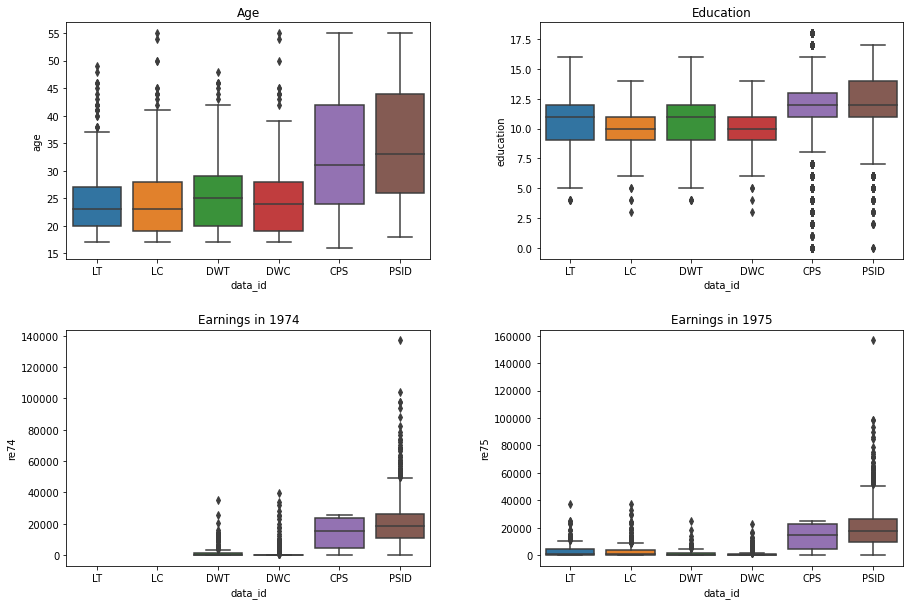

In [15]:
# Show boxplots
fn_boxplots(df = df)

The above boxplots show the distributions of pre-treatment continuous variables by group. Again, it is obvious that the distributions of the experimental data are totally different from those of CPS/PSID while the experimental treatment and control groups are similar to each other. In order to estimate ATE and ATET with CPS and PSID, we should take these differences into consideration.

## 3. Modeling

In this section, we will apply the following 4 estimation methods: regression, propensity score matching, IPTW estimator and doubly robust estimator.  
  
As a notation, we will let $D$ denote the treatment variable (`treat`), $X$ denote the covariates and $Y$ denote the outcome henceforth. Since `re74` is not available for LaLonde dataset, we define $X$ by the other pre-treatment variables, i.e., `age`, `education`, `black`, `hispanic`, `married`, `nodegree` and `re75`. We assume two kinds of outcomes $Y$, difference in earnings between 1975 and 1978 (`dif`) and earnings in 1978 (`re78`). If the experiments were randomized, the choice of $Y$ would not affect the estimates because the pre-treatment variable `re75` should be the same on average between treatment and control groups. On the other hand, it could affect the estimates when we rely on nonexperimental data. Thus, we assume both outcomes to make our research comprehensive.

### 3.1 Regression

Before applying each model, let us provide some theoretical background that is essential for our estimation.

Under the assumption of unconfoundedness $Y_0, Y_1 \perp D | X$ where $Y_0$ and $Y_1$ are potential outcomes when treated and controlled, respectively, we can obtain ATE and ATET as

$$
\begin{align*}
ATE &\equiv E[Y_1 - Y_0] \\
    &= E_X[E[Y_1 - Y_0 | X]] \\
    &= E_X[E[Y_1|X] - E[Y_0 | X]] \\
    &= E_X[E[Y_1|X, D=1] - E[Y_0 | X, D=0]] \\
    &= E_X[E[Y|X, D=1] - E[Y|X, D=0]] \\
    &\equiv E_X[\mu_1 (X) - \mu_0 (X)], \\
ATET &\equiv E[Y_1 - Y_0 | D = 1] \\
     &= E[Y_1 | D = 1] - E[Y_0 | D = 1] \\
     &= E[Y| D = 1] - E_{X|D = 1}[E[Y_0 | X, D = 1]| D = 1] \\
     &= E[Y| D = 1] - E_{X|D = 1}[E[Y_0 | X, D = 0]| D = 1] \\
     &= E[Y| D = 1] - E_{X|D = 1}[E[Y | X, D = 0]| D = 1] \\
     &= E[Y| D = 1] - E_{X|D = 1}[\mu_0 (X)| D = 1]
\end{align*}
$$

respectively, where $\mu_1 (X) \equiv E[Y | D = 1, X]$ and $\mu_0 (X) \equiv E[Y | D = 0, X]$ are conditional means of $Y$.

In this section, we try to estimate $\mu_1 (X)$ and $\mu_0 (X)$ using different regression models: i) linear regression, ii) Random Forest regression and iii) Gradient Boosting regression. If we can obtain the estimates $\hat{\mu}_1 (X)$ and $\hat{\mu}_0 (X)$, we can estimate ATE and ATET by

$$
\begin{align*}
\hat{\tau}_{ATE} &= \frac{1}{n} \sum_{i = 1}^n \left( \hat{\mu}_1 (X_i) - \hat{\mu}_0 (X_i) \right),\\
\hat{\tau}_{ATET} &= \frac{1}{n_1} \sum_{i|D_i = 1} \left( Y_i - \hat{\mu}_0 (X_i) \right),
\end{align*}
$$

respectively, where $n$ is the sample size and $n_1 \equiv \sum_{i = 1}^n D_i$ is the size of treatment group.  
  
If $\hat{\mu}_1 (X)$ and $\hat{\mu}_0 (X)$ are valid estimators, it should hold that

$$
\sum_{i|D_i = 1} \hat{\mu}_1 (X_i) =  \sum_{i|D_i = 1} Y_i, \sum_{i|D_i = 0} \hat{\mu}_0 (X_i) =\sum_{i|D_i = 0} Y_i.
$$

This condition can be easily understood considering the regression with the intercept. Thus, it can be shown that

$$
\begin{align*}
\hat{\tau}_{ATE} &= \frac{1}{n} \left[ \sum_{i|D_i = 1} \left( Y_i - \hat{\mu}_0 (X_i) \right) + \sum_{i|D_i = 0} \left( \hat{\mu}_1 (X_i) - Y_i \right) \right].\\
\end{align*}
$$

This explains why the above estimators are called regression imputation estimators (e.g., Abadie & Cattaneo, 2018). These estimators essentially try to impute the unobserved potential outcomes by regression.

#### 3.1.1 Linear Regression

We first apply linear regression models to obtain ATE/ATET estimates. In the linear regression model, we simply assume

$$
E[Y|D, X] = \alpha + \tau D + X \beta,
$$

which implies $E[Y|D = 1, X] - E[Y|D = 0, X] = \tau$. Thus, in this specification, both ATE and ATET will be identical to $\tau$.  
  
We run OLS to obtain the estimate for $\tau$. When experimental data are used, the OLS estimator for $\tau$ would be unbiased regardless of the covariates whereas adding covariates can help reduce the standard error of the estimate. Since all the covariates are pre-treatment variables, we do not have to worry about inducing a selection bias.  
  
For comparison, we specify three sets of covariates: i) no covariates, ii) age and squared age, and iii) age, squared age and all the other pre-treatment variables. We use squared values of `age` for ii) and iii) following LaLonde (1986). 

First, we assume the difference in earnings between 1975 and 1978 (`dif`) as outcome $Y$. As a benchmark, we obtain ATE/ATET estimates with experimental data below.

In [16]:
# Obtain benchmark experimental ATE/ATET estimates with LaLonde dataset
fn_regression_result(outcome = 'dif', treat_id = 'LT', control_id = 'LC', df = df)

Dependent Variable: Difference between 1975 and 1978
Treatment: LaLonde
Control: LaLonde


<class 'statsmodels.iolib.summary2.Summary'>
"""

==============================================================
               Without control    With age   With all controls
--------------------------------------------------------------
treat          846.8883        856.9110      800.5353*        
               (560.1417)      (557.6783)    (468.1002)       
age                            -703.6823***  -140.3273        
                               (241.6312)    (214.1023)       
age2                           11.5827***    2.6795           
                               (4.0793)      (3.5850)         
education                                    195.0935         
                                             (181.5737)       
black                                        -1441.5833*      
                                             (801.7171)       
hispanic                                     68.3112          
                                             (1047.2061)      
married                                      120.3331         
                                             (655.6825)       
nodegree                                     -498.1449        
                                             (744.0851)       
re75                                         -0.8249***       
                                             (0.0471)         
Intercept      2063.3655***    11841.9780*** 5817.5416        
               (359.2589)      (3380.1524)   (3675.6142)      
R-squared      0.0032          0.0148        0.3193           
R-squared Adj. 0.0018          0.0107        0.3107           
==============================================================
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
"""

As we have explained above, the coefficient on `treat` would be the estimate for ATE and ATET. The table shows that the esimate is quite stable across different modeling specifications, which is around 800&ndash;900 when we use LaLonde dataset. Assuming that the experiments were truly randomized, which appears to be a reasonable assumption considering the comparable distributions shown in Section 2, we can use these results as a benchmark for ATE/ATET estimates of LaLonde dataset. Simply said, our goal is to obtain nonexperimental ATE/ATET estimates that are close to 800&ndash;900 comparing treatment group of LaLonde dataset and CPS or PSID.

Now we run OLS over DW subset with the same modeling specifications.

In [17]:
# Obtain benchmark experimental ATE/ATET estimates with DW subset
fn_regression_result(outcome = 'dif', treat_id = 'DWT', control_id = 'DWC', df = df)

Dependent Variable: Difference between 1975 and 1978
Treatment: Dehejia and Wahba
Control: Dehejia and Wahba


<class 'statsmodels.iolib.summary2.Summary'>
"""

============================================================
               Without control   With age  With all controls
------------------------------------------------------------
treat          1529.1961**     1516.9969** 1636.1083**      
               (679.5380)      (682.2371)  (638.3005)       
age                            -46.6970    146.4019         
                               (279.9331)  (274.4144)       
age2                           1.1926      -1.5624          
                               (4.6231)    (4.4943)         
education                                  369.3361         
                                           (229.6550)       
black                                      -2121.4107*      
                                           (1169.9945)      
hispanic                                   125.7373         
                                           (1551.8464)      
married                                    -219.6153        
                                           (891.9255)       
nodegree                                   -192.7806        
                                           (998.1547)       
re75                                       -0.8559***       
                                           (0.1027)         
Intercept      3287.8921***    3650.0468   -28.0704         
               (438.1468)      (3987.1196) (4800.8266)      
R-squared      0.0113          0.0120      0.1729           
R-squared Adj. 0.0091          0.0053      0.1558           
============================================================
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
"""

Notably, the ATE/ATET estimates with DW subset is much larger than those with LaLonde dataset. It is about 1,500&ndash;1,600, which would be the benchmark for DW subset.

Now we will try to replicate these results using nonexperimental data. To do so, we replace experimental control group by nonexperimental data (CPS or PSID) and apply the same methods.  

First, we create the data that consists of treatment group of LaLonde dataset (`'LT'`) and CPS or PSID. If the unconfoundedness holds and our modeling specification $E[Y|D, X] = \alpha + \tau D + X \beta$ is correct, we should be able to get similar results even when using CPS or PSID as the control group. The following tables show the regression results.

In [18]:
# Obtain nonexperimental ATE/ATET estimates with LaLonde treatment and CPS
fn_regression_result(outcome = 'dif', treat_id = 'LT', control_id = 'CPS', df = df)

Dependent Variable: Difference between 1975 and 1978
Treatment: LaLonde
Control: CPS


<class 'statsmodels.iolib.summary2.Summary'>
"""

==============================================================
               Without control    With age   With all controls
--------------------------------------------------------------
treat          1714.3977***    195.1746      -999.6094**      
               (452.2939)      (441.8344)    (451.8801)       
age                            -561.3006***  -60.2642         
                               (36.6097)     (41.1105)        
age2                           5.7530***     -0.2232          
                               (0.5158)      (0.5624)         
education                                    139.2424***      
                                             (29.0907)        
black                                        -855.1777***     
                                             (215.0451)       
hispanic                                     -392.5577*       
                                             (221.4088)       
married                                      417.9360***      
                                             (151.8964)       
nodegree                                     160.7473         
                                             (180.8468)       
re75                                         -0.2915***       
                                             (0.0070)         
Intercept      1195.8561***    12792.5396*** 5522.0057***     
               (61.0734)       (600.9403)    (741.8697)       
R-squared      0.0009          0.0581        0.1498           
R-squared Adj. 0.0008          0.0579        0.1494           
==============================================================
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
"""

In [19]:
# Obtain nonexperimental ATE/ATET estimates with LaLonde treatment and PSID
fn_regression_result(outcome = 'dif', treat_id = 'LT', control_id = 'PSID', df = df)

Dependent Variable: Difference between 1975 and 1978
Treatment: LaLonde
Control: PSID


<class 'statsmodels.iolib.summary2.Summary'>
"""

============================================================
               Without control   With age  With all controls
------------------------------------------------------------
treat          419.6706        -749.2072   -1347.7964*      
               (650.5836)      (691.9516)  (804.4751)       
age                            25.8463     183.2980         
                               (154.1027)  (153.2805)       
age2                           -2.1310     -3.2828          
                               (2.1075)    (2.0895)         
education                                  657.1983***      
                                           (103.2634)       
black                                      -582.3745        
                                           (491.1658)       
hispanic                                   1964.4774*       
                                           (1028.3030)      
married                                    1483.4322**      
                                           (583.9112)       
nodegree                                   554.1020         
                                           (635.8372)       
re75                                       -0.2234***       
                                           (0.0164)         
Intercept      2490.5833***    4410.2647*  -4628.9051       
               (212.3796)      (2636.9688) (2846.1866)      
R-squared      0.0001          0.0156      0.0841           
R-squared Adj. -0.0002         0.0145      0.0812           
============================================================
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
"""

Compared to the experimental estimates, the nonexperimental estimates vary significantly depending on the modeling specifications and selection of control groups. It ranges from negative to positive values, and even worse, some of the results are statistically significant, which is misleading for researchers&mdash;they can easily overstate or understate the causal effect of the NSW. Unfortunately, none of them could generate a similar estimate to the benchmark (800&ndash;900). It seems that controlling for $X$ would not lead us to a correct estimate of ATE/ATET, which is the main implication of LaLonde (1986).

We apply the same linear regression methods to DW subset as well. To save the space, we do not show all the regression results but only the estimated coefficients $\hat{\tau}$ for each sample. The following table summarizes all the results including those with LaLonde dataset.

In [20]:
# Summarize the linear regression results for dif
reg_summary_dif = fn_regression_summary(df = df, outcome = 'dif')
reg_summary_dif

Outcome Treatment Control  Without control     With age  With all controls
0     dif        LT      LC       846.888287   856.910955         800.535314
1     dif        LT     CPS      1714.397705   195.174602        -999.609429
2     dif        LT    PSID       419.670577  -749.207210       -1347.796366
3     dif       DWT     DWC      1529.196083  1516.996931        1636.108327
4     dif       DWT     CPS      3621.232061  2383.311533         622.547024
5     dif       DWT    PSID      2326.504934  1256.927930         455.570948

Remember that `'DWT'` represents the treatment group of DW subset. The table implies that we fail to replicate experimental estimates with DW subset and nonexperimental data. The nonexperimental ATE/ATET estimates differ to a great extent depending on modeling specifications and choice of control group. None of the nonexperimental estimates are close to the benchmark, which is around 1,500&ndash;1,600.  
  
We also assume the earnings in 1978 (`re78`) as outcome below. The following table presents the results of $\hat{\tau}$ when `re78` is used as outcome instead of `dif`.

In [21]:
# Summarize the linear regression results for earnings in 1978
reg_summary_re78 = fn_regression_summary(df = df, outcome = 're78')
reg_summary_re78

Outcome Treatment Control  Without control      With age  With all controls
0    re78        LT      LC       886.303722    881.739626         800.535314
1    re78        LT     CPS     -8870.307627  -7172.308044        -999.609429
2    re78        LT    PSID    -15577.568900 -13267.657059       -1347.796366
3    re78       DWT     DWC      1794.342382   1736.057724        1636.108327
4    re78       DWT     CPS     -8497.516148  -7274.306837         622.547024
5    re78       DWT    PSID    -15204.777421 -13268.950367         455.570948

The table implies that even when using `re78` as the dependent variable, we could get similar experimental estimates to the above, which are 800&ndash;900 for LaLonde dataset and 1,600&ndash;1,800 for DW subset. By design, we get exactly the same results in the column of `With all controls` as in the case of `dif` because our covariates include `re75` (note that `dif` is defined by `re78` minus `re75`). Again, the nonexperimental estimates fail to generate results close to the benchmark.  
  
Here, we conclude that linear regression fails to replicate experimental results with nonexperimental data. That is possibly because i) unconfoundedness fails to hold or ii) the specification of the linear model is wrong. We will apply other regression methods to see if ii) is true. Note that the assumption of unconfoundedness is not testable.

In [22]:
# Output the results as .csv file
df_lr = pd.concat([reg_summary_dif, reg_summary_re78], axis = 0)
df_lr.to_csv('./results/linear_regression.csv', index = False)

#### 3.1.2 Random Forest Regression

Now we will estimate $\mu_d (X = x) = f(d, x)$ using a machine learning approach.  

First, we fit $Y = f(D, X)$ by Random Forest and get the estimator $\hat{f}(D, X)$. Then, ATE and ATET estimates are given by the following sample averages:

$$
\begin{align*}
\hat{\tau}_{ATE} &= \frac{1}{n} \left[ \sum_{i|D_i = 1} \left( Y_i - \hat{f}(0, X_i) \right) + \sum_{i|D_i = 0} \left( \hat{f}(1, X_i) - Y_i \right) \right],\\
\hat{\tau}_{ATET} &= \frac{1}{n_1} \sum_{i|D_i = 1} \left( Y_i - \hat{f}(0, X_i) \right).
\end{align*}
$$

Random Forest often performs well for prediction problem, and it is among the most widely used machine learning methods currently (Müller & Guido, 2016). Random Forest can predict a highly nonlinear relationship between dependent and independent variables, so we expect that it can potentially give us nonexperimental estimates that are closer to experimental ones than linear regression.  

We tune two hyperparameters for Random Forest, the number of trees in the forest (`n_estimators`) and the number of features considered for splitting (`max_features`) henceforth, to avoid overfitting and underfitting. The hyperparameter tuning is implemented by 5-fold cross validation.

The following table shows our estimates of ATE and ATET.

In [23]:
# ATE/ATET estimates using Random Forest regression
param_grid = {'n_estimators': [10, 50, 100, 500],
              'max_features': [2, 4, 6]}

RF_summary = fn_ML_results(df = df, method = 'RF', param_grid = param_grid)
RF_summary[RF_summary.Outcome == 'dif'].reset_index(drop = True)

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [13:27<00:00, 403.70s/it]


Outcome Treatment Control      Method Est_Imput          ATE         ATET
0     dif        LT      LC  Regression        RF   840.597285   661.812697
1     dif        LT     CPS  Regression        RF -4152.374393  -280.294032
2     dif        LT    PSID  Regression        RF -1989.601305 -1310.609442
3     dif       DWT     DWC  Regression        RF  1461.802766  1514.054702
4     dif       DWT     CPS  Regression        RF -1119.575317  1197.687076
5     dif       DWT    PSID  Regression        RF    10.739112  -219.428083

Unfortunately, we fail to replicate experimental benchmarks by applying Random Forest regression to nonexperimental data. The ATET estimate with treatment group of DW subset and CPS control group generates a similar estimate to benchmark, but it can be just a coincidence. The estimates are very sensitive to modeling specifications and differ greatly across different control groups.  

The following table shows the results when we use earnings in 1978 (`re78`) as outcome.

In [24]:
# ATE/ATET estimates using Random Forest regression
RF_summary[RF_summary.Outcome == 're78'].reset_index(drop = True)

Outcome Treatment Control      Method Est_Imput          ATE         ATET
0    re78        LT      LC  Regression        RF   878.072534   784.405159
1    re78        LT     CPS  Regression        RF -3020.025383  -307.202727
2    re78        LT    PSID  Regression        RF -6110.520853 -1680.443995
3    re78       DWT     DWC  Regression        RF  1504.468808  1568.285453
4    re78       DWT     CPS  Regression        RF  -873.916539  1136.545393
5    re78       DWT    PSID  Regression        RF -4567.665416  -789.320493

The implications are basically the same. The ATET estimate with `'DWT'` and `'CPS'` generates a somewhat close value to benchmark, but the estimate is not so useful considering its high sensitivity to modeling specifications such as the choice of control group.

#### 3.1.3 Gradient Boosting Regression

Now we fit $Y = f(D, X)$ by Gradient Boosting. Gradient Boosting is another ensemble method that combines multiple decision trees. It frequently becomes a winner in machine learning competitions (Müller & Guido, 2016). We expect that it can provide different nonlinear estimations of $Y = f(D, X)$ than Random Forest and make our analysis comprehensive. As in 3.1.2, ATE and ATET estimates are given by

$$
\begin{align*}
\hat{\tau}_{ATE} &= \frac{1}{n} \left[ \sum_{i|D_i = 1} \left( Y_i - \hat{f}(0, X_i) \right) + \sum_{i|D_i = 0} \left( \hat{f}(1, X_i) - Y_i \right) \right],\\
\hat{\tau}_{ATET} &= \frac{1}{n_1} \sum_{i|D_i = 1} \left( Y_i - \hat{f}(0, X_i) \right),
\end{align*}
$$

where $\hat{f}(D_i, X_i)$ is obtained by Gradient Boosting now. We consider exactly the same hyperparameters, `n_estimators` and `max_features`, for Gradient Boosting as well. The advantage of Gradient Boosting is that it is fairly robust to overfitting and generally less time-consuming than Random Forest. While we have tuned the hyperparameters over the same candidates, the runtime has turned out to be much shorter than in 3.1.2. Again, the hyperparameters are tuned by 5-fold cross validation.  

The following table shows the estimates when we use `dif` as the dependent variable.

In [25]:
# ATE/ATET estimates using Gradient Boosting regression
param_grid = {'n_estimators': [10, 50, 100, 500],
              'max_features': [2, 4, 6]}

GB_summary = fn_ML_results(df = df, method = 'GB', param_grid = param_grid)
GB_summary[GB_summary.Outcome == 'dif'].reset_index(drop = True)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [02:55<00:00, 87.64s/it]


Outcome Treatment Control      Method Est_Imput          ATE         ATET
0     dif        LT      LC  Regression        GB   556.496136   611.985555
1     dif        LT     CPS  Regression        GB -4321.463915  -591.669821
2     dif        LT    PSID  Regression        GB    23.565776   -32.876449
3     dif       DWT     DWC  Regression        GB  1062.094593  1157.052485
4     dif       DWT     CPS  Regression        GB -1917.804119  1094.496193
5     dif       DWT    PSID  Regression        GB   110.837982  1617.855773

Just like Random Forest, Gradient Boosting fails to replicate experimental estimates with nonexperimental data. Similarly to the case of Random Forest, the ATET estimate with `'DWT'` and `'CPS'` is relatively correct, but we should not consider it as improvement over linear regression because the estimates are not robust but vary greatly across different models. Actually, as the following table presents, the ATET estimate with `'DWT'` and `'CPS'` will be far from the benchmark when we use `re78` as outcome.  

In [26]:
# ATE/ATET estimates using Gradient Boosting regression
GB_summary[GB_summary.Outcome == 're78'].reset_index(drop = True)

Outcome Treatment Control      Method Est_Imput          ATE         ATET
0    re78        LT      LC  Regression        GB   529.687722   588.058800
1    re78        LT     CPS  Regression        GB -4327.258744  -899.303045
2    re78        LT    PSID  Regression        GB -6383.741218 -1972.777983
3    re78       DWT     DWC  Regression        GB  1056.690317  1163.503599
4    re78       DWT     CPS  Regression        GB -1088.168411   679.754935
5    re78       DWT    PSID  Regression        GB -2120.980991 -1367.647377

The above table shows ATE and ATET estimates when outcome is `re78`. We can see that none of the nonexperimental estimates is close to the benchmarks. Therefore, unfortunately, Gradient Boosting regression has not improved our nonexperimental estimations.

In [27]:
# Output the results as .csv file
df_MLreg = pd.concat([RF_summary, GB_summary], axis = 0)
df_MLreg.to_csv('./results/ML_regression.csv', index = False)

Overall, regression methods fail to replicate experimental estimates of ATE and ATET with nonexperimental data. The results have not been improved even when we rely on machine learning methods such as Random Forest and Gradient Boosting. This implies the possibility that the assumption of unconfoundedness might not hold with our data&mdash;there might be an important unobservable variable.

In the following subsections, we will see if propensity score methods can improve the situation.

### 3.2 Propensity Score Matching

In this subsection, we will apply the propensity score matching method following Dehejia and Wahba (1999, 2002). First, we will provide some technical background. 
  
The propensity score is defined by $p(X) \equiv \mathrm{Pr}(D = 1 | X)$. Suppose the assumption of unconfoundedness $Y_0, Y_1 \perp D | X$ holds again. Then, the law of iterated expectations implies that

$$
\begin{align*}
\mathrm{Pr}(D = 1 | p(X))  &= E_{X|p(X)}[\mathrm{Pr}(D = 1 | X, p(X))|p(X)] \\
                           &= E_{X|p(X)}[\mathrm{Pr}(D = 1 | X)|p(X)] \\
                           &\equiv E_{X|p(X)}[p(X)|p(X)] \\
                           &= p(X) \\
                           &\equiv \mathrm{Pr}(D = 1 | X).
\end{align*}
$$

Thus,

$$
\begin{align*}
\mathrm{Pr}(D = 1|Y_0, Y_1, p(X)) &= E_{X|Y_0, Y_1, p(X)}[\mathrm{Pr}(D = 1|Y_0, Y_1, p(X), X)|Y_0, Y_1, p(X)] \\
                                  &= E_{X|Y_0, Y_1, p(X)}[\mathrm{Pr}(D = 1|Y_0, Y_1, X)|Y_0, Y_1, p(X)] \\
                                  &= E_{X|Y_0, Y_1, p(X)}[\mathrm{Pr}(D = 1|X)|Y_0, Y_1, p(X)] \\
                                  &\equiv E_{X|Y_0, Y_1, p(X)}[p(X)|Y_0, Y_1, p(X)] \\
                                  &= p(X) \\
                                  &\equiv \mathrm{Pr}(D = 1 | X) \\
                                  &= \mathrm{Pr}(D = 1 | p(X)),
\end{align*}
$$

which implies $Y_0, Y_1 \perp D | p(X)$.  

Therefore, replacing $X$ by $p(X)$ in 3.1, we can obtain ATE and ATET as

$$
\begin{align*}
ATE  &= E_{p(X)}[E[Y|p(X), D = 1] - E[Y|p(X), D = 0]],\\
ATET &= E[Y| D = 1] - E_{p(X)|D = 1}[E[Y | p(X), D = 0]| D = 1].
\end{align*}
$$

These formula motivate us to match samples based on propensity score. The propensity score substantially reduces the dimensionality of covatiates $X$. Roughly speaking, it is much easier to control for $p(X)$ than $X$. Comparing the samples that have similar propensity scores, we can virtually control for $p(X)$ and estimate ATE and ATET.  

Let us start with ATET. The first term of ATET, $E[Y| D = 1]$, can be estimated by average of treated outcome, so what we should do is to estimate the second term $E_{p(X)|D = 1}[E[Y | p(X), D = 0]| D = 1]$. The propensity score matching method enables us to estimate it by the following steps:
1. Estimate $p(X)$ by $\hat{p}(X)$.
2. Compute $\mathrm{logit}(X_i) \equiv \ln (\frac{\hat{p}(X_i)}{1 - \hat{p}(X_i)})$ for all the samples $i = 1, \ldots, n$.
3. For each sample $i$ such that $D_i = 1$ (i.e., treated sample), we match a set of samples $J_i$ from control group (i.e., $D_j = 0$ for $j \in J_i$) so that $\mathrm{logit}(X_j)$ is sufficiently close to $\mathrm{logit}(X_i)$ for $j \in J_i$. $J_i$ can include multiple samples. We define maximum number of matched samples $|J_i|$ and/or maximum difference in $|\mathrm{logit}(X_i) - \mathrm{logit}(X_j)|$ (caliper) to identify matched samples.
4. Then, ATET is estimated by

$$
\hat{\tau}_{ATET} = \frac{1}{n_1} \sum_{i|D_i = 1} \left( Y_i - \frac{1}{|J_i|} \sum_{j \in J_i} Y_j \right).
$$

Similarly, we can estimate average treatment effect on controlled (ATEC) by

$$
\hat{\tau}_{ATEC} = \frac{1}{n_0} \sum_{i|D_i = 0} \left( \frac{1}{|J_i|} \sum_{j \in J_i} Y_j - Y_i\right),
$$

where $n_0 \equiv \sum_{i = 1}^n (1 - D_i)$ is the size of control group. Then, we can estimate ATE by the weighted average of $\hat{\tau}_{ATET}$ and $\hat{\tau}_{ATEC}$:

$$
\hat{\tau}_{ATE} = \frac{n_1}{n} \hat{\tau}_{ATET} + \frac{n_0}{n} \hat{\tau}_{ATEC}.
$$

The matching method essentially tries to estimate ATET by choosing a comparable sample with treatment group from control group. Therefore, in order for the method to work, the distribution of matched samples should be similar to that of the treated samples in pre-treatment characteristics. In this subsection, we first try to estimate the propensity score by three methods, logistic regression, Random Forest and Gradient Boosting, and match the samples based on the estimates. Then, we compare the distribution of matched nonexperimental samples with that of treated samples and see whether the matching method could successfully pick up comparable samples from nonexperimental data.  

Note that we will omit samples with the estimated propensity score that is close to 0 or 1. Specifically, we will keep only the samples whose estimated propensity score satisfies $0.01 < \hat{p}(X_i) < 0.99$ for 3.2, 3.3 and 3.4. The trimming is common in propensity score methods, which basically sacrifices external validity for improved accuracy.

#### 3.2.1 Logistic Regression

First, we estimate the propensity score by logistic regression. That is, our model can be specified as

$$
\mathrm{Pr}(D_i = 1| X_i) = \frac{\exp(\alpha + X_i \beta)}{1 + \exp(\alpha + X_i \beta)},
$$

where $X_i$ consists of linear terms of pre-treatment covariates, i.e., `age`, `education`, `black`, `hispanic`, `married`, `nodegree` and `re75`. We first run a logistic regression on treatment group of LaLonde dataset and CPS, and pick up CPS samples that are comparable to each sample of treatment group. For now, we do not fix a caliper and pick up 5 nearest samples in terms of logit of propensity score. The following table summarizes our matching results.

In [28]:
# Propensity score matching with LaLonde and CPS
phat_logit_LT_CPS = fn_propensity_score(treat_id = 'LT', control_id = 'CPS', df = df, method = 'logit')

df_matched = fn_generate_df_matched(treat_id = 'LT', control_id = 'CPS', outcome = 'dif', df = df,
                                    prop = phat_logit_LT_CPS, n_neighbors = 5)
df_matched.head(10)

data_id  treat   age  education  black  hispanic  married  nodegree  re75  \
0      LT    1.0  37.0       11.0    1.0       0.0      1.0       1.0   0.0   
1      LT    1.0  22.0        9.0    0.0       1.0      0.0       1.0   0.0   
2      LT    1.0  30.0       12.0    1.0       0.0      0.0       0.0   0.0   
3      LT    1.0  27.0       11.0    1.0       0.0      0.0       1.0   0.0   
4      LT    1.0  33.0        8.0    1.0       0.0      0.0       1.0   0.0   
5      LT    1.0  22.0        9.0    1.0       0.0      0.0       1.0   0.0   
6      LT    1.0  23.0       12.0    1.0       0.0      0.0       0.0   0.0   
7      LT    1.0  32.0       11.0    1.0       0.0      0.0       1.0   0.0   
8      LT    1.0  22.0       16.0    1.0       0.0      0.0       0.0   0.0   
9      LT    1.0  19.0        9.0    1.0       0.0      0.0       1.0   0.0   

           re78           dif  propensity_score  propensity_score_logit  \
0   9930.045898   9930.045898          0.213584               -1.303455   
1   3595.894043   3595.894043          0.137609               -1.835291   
2  24909.449219  24909.449219          0.247696               -1.110939   
3   7506.145996   7506.145996          0.540837                0.163711   
4    289.789886    289.789886          0.458722               -0.165489   
5   4056.493896   4056.493896          0.537262                0.149326   
6      0.000000      0.000000          0.278597               -0.951431   
7   8472.158203   8472.158203          0.512442                0.049777   
8   2164.021973   2164.021973          0.338048               -0.672006   
9   8173.908203   8173.908203          0.554208                0.217686   

   matched_index_1  matched_index_2  matched_index_3  matched_index_4  \
0           1543.0            920.0           1426.0           1721.0   
1           1234.0           1105.0           1201.0           1397.0   
2            531.0           2514.0            374.0           2391.0   
3           2161.0           1946.0            430.0           2260.0   
4           2533.0           1820.0           1513.0           1567.0   
5            909.0            761.0            282.0            314.0   
6            420.0            551.0           1083.0           1568.0   
7            729.0            587.0           1818.0           1821.0   
8           1126.0           1351.0           2540.0           1343.0   
9           1812.0           1921.0           1232.0           1259.0   

   matched_index_5  matched_outcome_1  matched_outcome_2  matched_outcome_3  \
0           2429.0           0.000000       -2467.633301        2478.801147   
1           2227.0        2611.256226         281.933594        4613.690430   
2            538.0        1898.879028        1161.493042       -3242.273926   
3            909.0        -519.932495        3723.899109        -961.403198   
4           1516.0        3695.935547        1556.045898       -2846.613037   
5           1365.0        7919.249878       11594.666382        -451.161285   
6           1389.0       12538.509766           0.000000        7062.055176   
7           1906.0       22859.492920        7443.645752        5869.643311   
8           1982.0         116.740402       -3231.531982           0.000000   
9            661.0           0.000000           0.000000        -823.832581   

   matched_outcome_4  matched_outcome_5  distance_1  distance_2  distance_3  \
0        5054.507080       -3043.548096    0.010222    0.012320    0.022718   
1        -742.955078        4676.322266    0.000079    0.002396    0.003736   
2       16833.356934       24360.320312    0.000000    0.000000    0.010412   
3        2713.105957        7919.249878    0.001348    0.006133    0.010611   
4       -2306.532104        4344.032959    0.008529    0.010462    0.010998   
5       15315.412720         278.011597    0.000079    0.002526    0.002655   
6          91.619049        6831.132370    0.000000    0.000000    0.000000   


Here, we have added the following columns to the data frame:  

- `propensity_score`: estimated propensity score
- `propensity_score_logit`: logit of the propensity score estimate
- `matched_index_1` to `matched_index_5`: indices of matched samples
- `matched_outcome_1` to `matched_outcome_5`: outcomes of matched samples (outcome is `dif` here)
- `distance_1` to `distance_5`: difference in `propensity_score_logit` between treated sample and matched samples
- `matched_outcome_average`: average of outcomes of matched samples  

To see how comparable treatment and control groups become after the matching, we compare the distributions of pre-treatment variables using group-by averages and boxplots.

In [29]:
# Show averages by group
df_matched_treat = fn_generate_df_matched_treat(df_matched = df_matched, treat_id = 'LT')
fn_mean_by_group(df_matched_treat = df_matched_treat, treat_id = 'LT')

data_id                   CPS           LT
treat                0.000000     1.000000
age                 25.097473    24.440433
education           10.552347    10.292419
black                0.884477     0.859206
hispanic             0.086643     0.093863
married              0.133574     0.155235
nodegree             0.696751     0.768953
re75              3094.071600  2870.036685
re78              6244.413510  5942.459912
dif               3150.341910  3072.423227
propensity_score     0.323998     0.323956

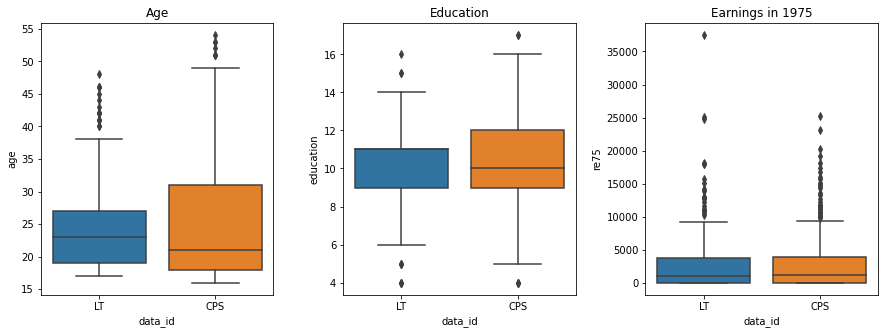

In [30]:
# Show boxplots
fn_boxplots(df = df_matched_treat, re74 = False)

Comparing them with the distributions before the matching (see 2.3.4), nonexperimental control group chosen from CPS has relatively a similar distribution to that of treatment group of LaLonde dataset now. The group-by averages of pre-treatment variables are close to each other. The boxplots still show differences in distributions between two groups, but the differences are much smaller than before the matching.

Similarly, we apply the same method to treatment group of LaLonde dataset and PSID. The following shows the distributional differences after the matching.

In [31]:
# Propensity score matching with LaLonde and PSID
phat_logit_LT_PSID = fn_propensity_score(treat_id = 'LT', control_id = 'PSID', df = df, method = 'logit')

df_matched = fn_generate_df_matched(treat_id = 'LT', control_id = 'PSID', outcome = 'dif', df = df,
                                    prop = phat_logit_LT_PSID, n_neighbors = 1)

# Show averages by group
df_matched_treat = fn_generate_df_matched_treat(df_matched = df_matched, treat_id = 'LT')
fn_mean_by_group(df_matched_treat = df_matched_treat, treat_id = 'LT')

data_id                    LT         PSID
treat                1.000000     0.000000
age                 24.513605    24.312925
education           10.394558    10.435374
black                0.802721     0.826531
hispanic             0.095238     0.105442
married              0.163265     0.156463
nodegree             0.727891     0.690476
re75              2859.766375  3233.145989
re78              5958.267558  7001.418233
dif               3098.501184  3768.272243
propensity_score     0.647568     0.647163

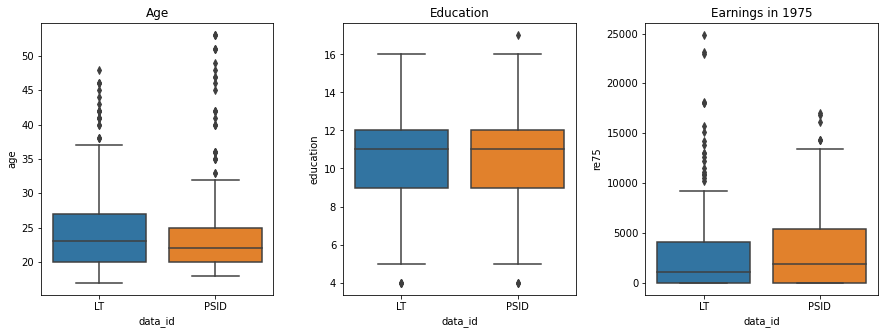

In [32]:
# Show boxplots
fn_boxplots(df = df_matched_treat, re74 = False)

Again, although there are still differences in distributions of two groups, they get much smaller than before the matching.

Next, we apply the matching method to DW subset and compate the distributions of treatment group of DW subset with those of matched samples picked from CPS and PSID. According to Dehejia and Wahba (1999, 2002), the propensity score matching method would successfully make these samples comparable.

In [33]:
# Propensity score matching with DW and CPS
phat_logit_DWT_CPS = fn_propensity_score(treat_id = 'DWT', control_id = 'CPS', df = df, method = 'logit')

df_matched = fn_generate_df_matched(treat_id = 'DWT', control_id = 'CPS', outcome = 'dif', df = df,
                                    prop = phat_logit_DWT_CPS, n_neighbors = 1)

# Show averages by group
df_matched_treat = fn_generate_df_matched_treat(df_matched = df_matched, treat_id = 'DWT')
fn_mean_by_group(df_matched_treat = df_matched_treat, treat_id = 'DWT')

data_id                   CPS          DWT
treat                0.000000     1.000000
age                 24.493976    25.620482
education           10.500000    10.216867
black                0.927711     0.915663
hispanic             0.036145     0.048193
married              0.156627     0.156627
nodegree             0.680723     0.746988
re75               945.376631  1053.871833
re78              5246.258639  6004.840528
re74              1668.480926  1676.139672
dif               4300.882008  4950.968694
propensity_score     0.299467     0.299375

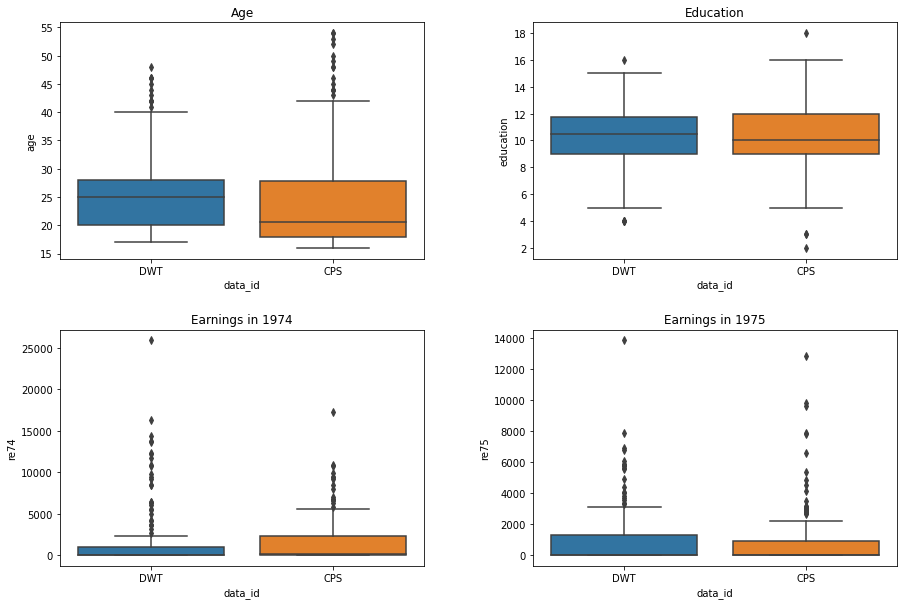

In [34]:
# Show boxplots
fn_boxplots(df = df_matched_treat, re74 = True)

In [35]:
# Propensity score matching with DW and PSID
phat_logit_DWT_PSID = fn_propensity_score(treat_id = 'DWT', control_id = 'PSID', df = df, method = 'logit')

df_matched = fn_generate_df_matched(treat_id = 'DWT', control_id = 'PSID', outcome = 'dif', df = df,
                                    prop = phat_logit_DWT_PSID, n_neighbors = 1)

# Show averages by group
df_matched_treat = fn_generate_df_matched_treat(df_matched = df_matched, treat_id = 'DWT')
fn_mean_by_group(df_matched_treat = df_matched_treat, treat_id = 'DWT')

data_id                   DWT         PSID
treat                1.000000     0.000000
age                 25.638889    25.033333
education           10.333333    10.455556
black                0.838889     0.888889
hispanic             0.061111     0.038889
married              0.166667     0.127778
nodegree             0.711111     0.727778
re75              1133.351571  1735.041407
re78              6117.885886  5943.539499
re74              1613.143910  3981.415164
dif               4984.534315  4208.498092
propensity_score     0.636215     0.636128

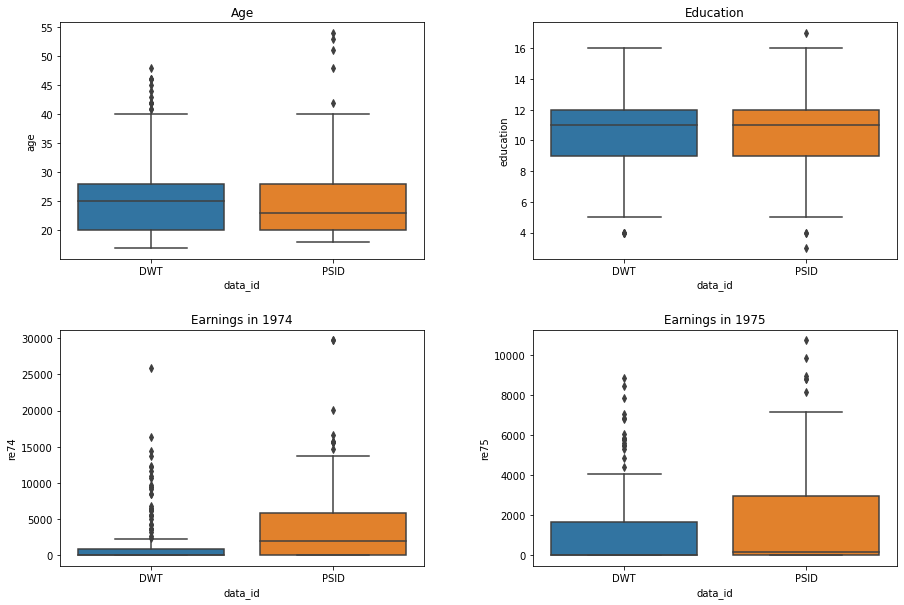

In [36]:
# Show boxplots
fn_boxplots(df = df_matched_treat, re74 = True)

As we can see, by applying the propensity score matching, we can make nonexperimental control group resemble the experimental treatment group for both CPS and PSID. This observation is roughly consistent with Dehejia and Wahba (1999, 2002) while their specification of logistic regression model is different from ours. They include, for example, squared values of `age`, `education` and `re75` and so forth.

Before computing ATE and ATET estimates, we apply machine learning methods (Random Forest and Gradient Boosting) for propensity score estimation and see if they can outperform logistic regression in terms of removing systematic differences between treatment and control groups.

#### 3.2.2 Random Forest Classification

Here we use Random Forest for propensity score estimation. We can interpret the propensity score estimation as classification problem, that is, prediction problem of whether a sample is treated or controlled based on pre-treatment variables $X$. The function `sklearn.ensemble.RandomForestClassifier()` can solve the classification problem for us. The function also returns the estimated probability of being treated for each sample, which can be used for our propensity score estimate. Again, the hyperparameters for Random Forest, `n_estimators` and `max_features`, are tuned by 5-fold cross validation.  

First, we estimate the propensity score with treatment group of LaLonde dataset and CPS, and pick up the matched samples from CPS accordingly. The results of the matching are summarized in the following table.

In [37]:
# Estimate propensity score by Random Forest
# Hyperparameters are tuned by cross validation
param_grid = {'n_estimators': [10, 50, 100, 500],
              'max_features': [2, 4, 6]}

# Propensity score matching with LaLonde and CPS
phat_RF_LT_CPS = fn_propensity_score(treat_id = 'LT', control_id = 'CPS', df = df, method = 'RF',
                                     param_grid = param_grid)

# Show the matched samples
df_matched = fn_generate_df_matched(treat_id = 'LT', control_id = 'CPS', outcome = 'dif', df = df,
                                    prop = phat_RF_LT_CPS, n_neighbors = 5)
df_matched.head(10)

data_id  treat   age  education  black  hispanic  married  nodegree  re75  \
0      LT    1.0  37.0       11.0    1.0       0.0      1.0       1.0   0.0   
1      LT    1.0  22.0        9.0    0.0       1.0      0.0       1.0   0.0   
2      LT    1.0  30.0       12.0    1.0       0.0      0.0       0.0   0.0   
3      LT    1.0  27.0       11.0    1.0       0.0      0.0       1.0   0.0   
4      LT    1.0  33.0        8.0    1.0       0.0      0.0       1.0   0.0   
5      LT    1.0  22.0        9.0    1.0       0.0      0.0       1.0   0.0   
6      LT    1.0  23.0       12.0    1.0       0.0      0.0       0.0   0.0   
7      LT    1.0  32.0       11.0    1.0       0.0      0.0       1.0   0.0   
8      LT    1.0  22.0       16.0    1.0       0.0      0.0       0.0   0.0   
9      LT    1.0  33.0       12.0    0.0       0.0      1.0       0.0   0.0   

           re78           dif  propensity_score  propensity_score_logit  \
0   9930.045898   9930.045898          0.645271                0.598318   
1   3595.894043   3595.894043          0.732000                1.004794   
2  24909.449219  24909.449219          0.325268               -0.729665   
3   7506.145996   7506.145996          0.988000                4.410776   
4    289.789886    289.789886          0.794000                1.349207   
5   4056.493896   4056.493896          0.839162                1.652005   
6      0.000000      0.000000          0.352401               -0.608503   
7   8472.158203   8472.158203          0.848238                1.720848   
8   2164.021973   2164.021973          0.449371               -0.203211   
9  12418.070312  12418.070312          0.068462               -2.610561   

   matched_index_1  matched_index_2  matched_index_3  matched_index_4  \
0            751.0            838.0           1105.0            862.0   
1            751.0            838.0           1105.0            862.0   
2           1132.0            391.0            884.0           1097.0   
3            751.0            838.0           1105.0            862.0   
4            751.0            838.0           1105.0            862.0   
5            751.0            838.0           1105.0            862.0   
6            399.0            772.0            343.0            582.0   
7            751.0            838.0           1105.0            862.0   
8            598.0            758.0            777.0           1074.0   
9            396.0            661.0            571.0            326.0   

   matched_index_5  matched_outcome_1  matched_outcome_2  matched_outcome_3  \
0            580.0           0.000000        1053.619019           0.000000   
1            580.0           0.000000        1053.619019           0.000000   
2            310.0        1161.493042        1898.879028        1642.463867   
3            580.0           0.000000        1053.619019           0.000000   
4            580.0           0.000000        1053.619019           0.000000   
5            580.0           0.000000        1053.619019           0.000000   
6            430.0           0.000000          91.619049       12538.509766   
7            580.0           0.000000        1053.619019           0.000000   
8            608.0         116.740402        8355.066406        3293.853027   
9            511.0           0.000000           0.000000           0.000000   

   matched_outcome_4  matched_outcome_5  distance_1  distance_2  distance_3  \
0           0.000000           0.000000    0.124202    0.124202    0.417715   
1           0.000000           0.000000    0.282273    0.282273    0.824190   
2        7543.793945       15315.412720    0.000000    0.000000    0.014931   
3           0.000000           0.000000    3.688256    3.688256    4.230172   
4           0.000000           0.000000    0.626687    0.626687    1.168604   
5           0.000000           0.000000    0.929485    0.929485    1.471402   
6        7062.055176        6083.799805    0.000000    0.000000    0.000000   


The definitions of columns are the same as in 3.2.1.  

Here we can see that relatively many treated samples are matched with the same nonexperimental samples. As we can see in the columns of `matched_index_1` to `matched_index_5`, the same indices are chosen as matched samples many times. This is different from the case of logistic regression where a variety of indices are chosen.  

As in 3.2.1, we compare the distributions of treatment and control groups after the matching below.

In [38]:
# Show averages by group
df_matched_treat = fn_generate_df_matched_treat(df_matched = df_matched, treat_id = 'LT')
fn_mean_by_group(df_matched_treat = df_matched_treat, treat_id = 'LT')

data_id                  CPS           LT
treat               0.000000     1.000000
age                17.820339    24.613559
education          10.138983    10.376271
black               0.979661     0.800000
hispanic            0.000000     0.094915
married             0.013559     0.169492
nodegree            0.955932     0.728814
re75                0.000000  3078.465460
re78              267.929375  5958.459627
dif               267.929375  2879.994167
propensity_score    0.640710     0.738060

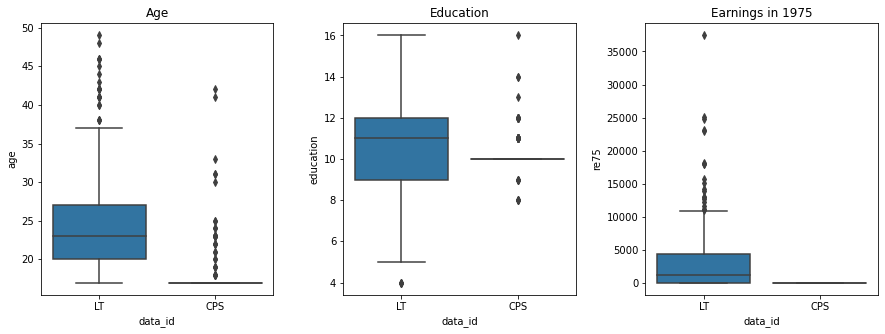

In [39]:
# Show boxplots
fn_boxplots(df = df_matched_treat, re74 = False)

The above table and figure imply that, surprisingly, there are large differences between treatment and control groups. For example, **all** the matched samples from CPS have zero earnings in 1975. Furthermore, there are much more black people, dropouts and young people in the matched samples than in the treatment group of LaLonde dataset. Although these characteristics (i.e., black, dropouts, young and low earnings) were quite common in the NSW participants, Random Forest appears to have overcorrected the distribution of these variables in CPS. Therefore, unfortunately, we cannot expect that the matching based on Random Forest estimation would generate correct estimates of ATE/ATET.  

We apply Random Forest to PSID below.

In [40]:
# Propensity score matching with LaLonde and PSID
phat_RF_LT_PSID = fn_propensity_score(treat_id = 'LT', control_id = 'PSID', df = df, method = 'RF',
                                      param_grid = param_grid)

df_matched = fn_generate_df_matched(treat_id = 'LT', control_id = 'PSID', outcome = 'dif', df = df,
                                    prop = phat_RF_LT_PSID, n_neighbors = 1)

# Show averages by group
df_matched_treat = fn_generate_df_matched_treat(df_matched = df_matched, treat_id = 'LT')
fn_mean_by_group(df_matched_treat = df_matched_treat, treat_id = 'LT')

data_id                    LT         PSID
treat                1.000000     0.000000
age                 25.450199    24.613546
education           10.450199    11.848606
black                0.776892     0.992032
hispanic             0.099602     0.000000
married              0.199203     0.011952
nodegree             0.701195     0.159363
re75              3525.397370     0.000000
re78              5951.333419  1555.851809
dif               2425.936049  1555.851809
propensity_score     0.831361     0.762660

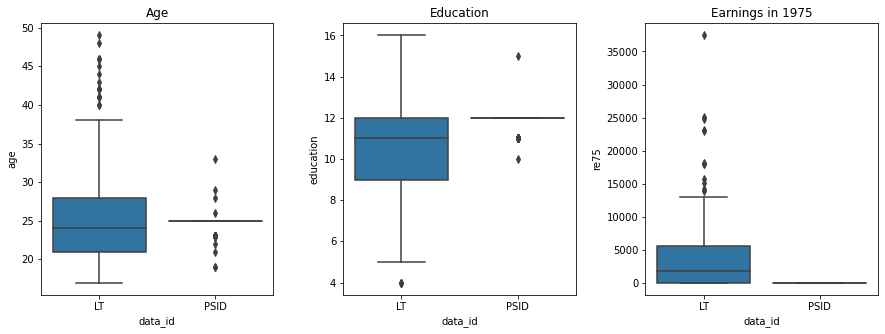

In [41]:
# Show boxplots
fn_boxplots(df = df_matched_treat, re74 = False)

Again, there are large distributional differences between treatment and control groups, which implies that Random Forest propensity score estimation fails to match appropriate samples.

We apply the same methods to DW subset below, resulting in similar results to the case of LaLonde dataset.

In [42]:
# Propensity score matching with DW and CPS
phat_RF_DWT_CPS = fn_propensity_score(treat_id = 'DWT', control_id = 'CPS', df = df, method = 'RF',
                                      param_grid = param_grid)

df_matched = fn_generate_df_matched(treat_id = 'DWT', control_id = 'CPS', outcome = 'dif', df = df,
                                    prop = phat_RF_DWT_CPS, n_neighbors = 1)

# Show averages by group
df_matched_treat = fn_generate_df_matched_treat(df_matched = df_matched, treat_id = 'DWT')
fn_mean_by_group(df_matched_treat = df_matched_treat, treat_id = 'DWT')

data_id                   CPS          DWT
treat                0.000000     1.000000
age                 18.237569    25.795580
education           10.209945    10.331492
black                0.966851     0.839779
hispanic             0.000000     0.060773
married              0.022099     0.193370
nodegree             0.928177     0.701657
re75                 0.000000  1565.912889
re78              1390.336603  6349.752169
re74               363.546858  2141.884714
dif               1390.336603  4783.839280
propensity_score     0.624409     0.703686

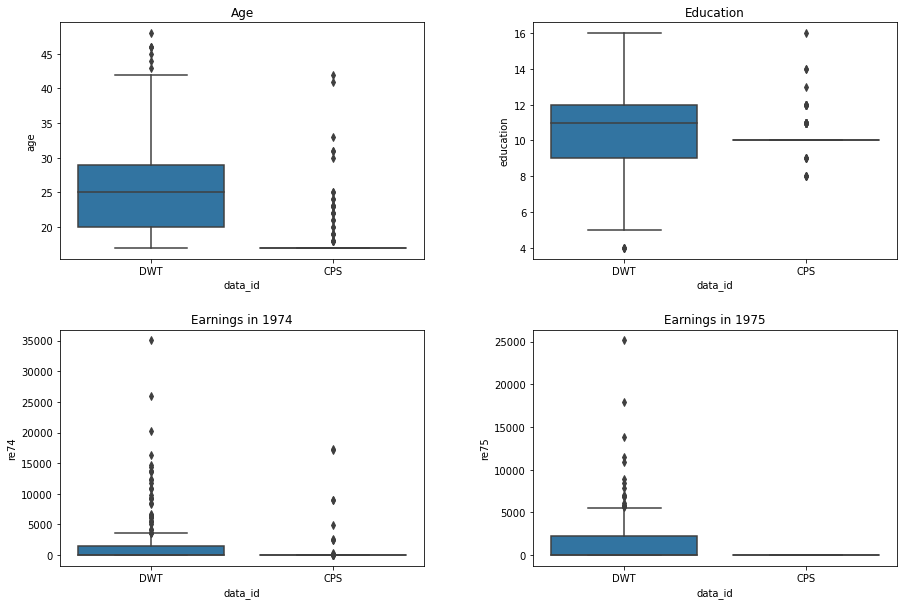

In [43]:
# Show boxplots
fn_boxplots(df = df_matched_treat, re74 = True)

In [44]:
# Propensity score matching with DW and PSID
phat_RF_DWT_PSID = fn_propensity_score(treat_id = 'DWT', control_id = 'PSID', df = df, method = 'RF',
                                       param_grid = param_grid)

df_matched = fn_generate_df_matched(treat_id = 'DWT', control_id = 'PSID', outcome = 'dif', df = df,
                                    prop = phat_RF_DWT_PSID, n_neighbors = 1)

# Show averages by group
df_matched_treat = fn_generate_df_matched_treat(df_matched = df_matched, treat_id = 'DWT')
fn_mean_by_group(df_matched_treat = df_matched_treat, treat_id = 'DWT')

data_id                   DWT         PSID
treat                1.000000     0.000000
age                 26.509202    24.539877
education           10.453988    11.852761
black                0.822086     0.987730
hispanic             0.067485     0.000000
married              0.214724     0.018405
nodegree             0.674847     0.159509
re75              1733.934509     0.000000
re78              6783.155541  1523.010291
re74              2378.411861   157.462544
dif               5049.221031  1523.010291
propensity_score     0.830065     0.756553

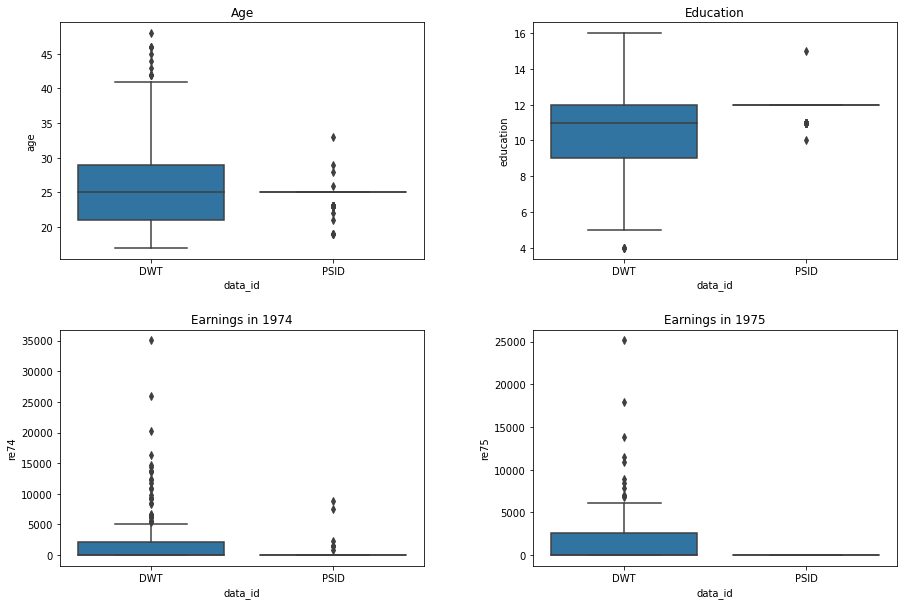

In [45]:
# Show boxplots
fn_boxplots(df = df_matched_treat, re74 = True)

Overall, the propensity score estimated by Random Forest fails to make treatment and control groups comparable. Thus, we conclude that Random Forest should not be an appropriate method for propensity score estimation in this application.

#### 3.2.3 Gradient Boosting Classification

Lastly, we estimate the propensity score by Gradient Boosting. The procedure is the same as Random Forest&mdash;predict treatment status based on covariates $X$ and use the estimated probabilities of being treated as estimates of propensity score.

In [46]:
# Estimate propensity score by Gradient Boosting
param_grid = {'n_estimators': [10, 50, 100, 500],
              'max_features': [2, 4, 6]}

# Propensity score matching with LaLonde and CPS
phat_GB_LT_CPS = fn_propensity_score(treat_id = 'LT', control_id = 'CPS', df = df, method = 'GB',
                                     param_grid = param_grid)

df_matched = fn_generate_df_matched(treat_id = 'LT', control_id = 'CPS', outcome = 'dif', df = df,
                                    prop = phat_GB_LT_CPS, n_neighbors = 5)
df_matched.head(10)

data_id  treat   age  education  black  hispanic  married  nodegree  re75  \
0      LT    1.0  37.0       11.0    1.0       0.0      1.0       1.0   0.0   
1      LT    1.0  22.0        9.0    0.0       1.0      0.0       1.0   0.0   
2      LT    1.0  30.0       12.0    1.0       0.0      0.0       0.0   0.0   
3      LT    1.0  27.0       11.0    1.0       0.0      0.0       1.0   0.0   
4      LT    1.0  33.0        8.0    1.0       0.0      0.0       1.0   0.0   
5      LT    1.0  22.0        9.0    1.0       0.0      0.0       1.0   0.0   
6      LT    1.0  23.0       12.0    1.0       0.0      0.0       0.0   0.0   
7      LT    1.0  32.0       11.0    1.0       0.0      0.0       1.0   0.0   
8      LT    1.0  22.0       16.0    1.0       0.0      0.0       0.0   0.0   
9      LT    1.0  19.0        9.0    1.0       0.0      0.0       1.0   0.0   

           re78           dif  propensity_score  propensity_score_logit  \
0   9930.045898   9930.045898          0.250983               -1.093375   
1   3595.894043   3595.894043          0.426439               -0.296393   
2  24909.449219  24909.449219          0.396189               -0.421369   
3   7506.145996   7506.145996          0.834947                1.621099   
4    289.789886    289.789886          0.629847                0.531560   
5   4056.493896   4056.493896          0.778109                1.254678   
6      0.000000      0.000000          0.442726               -0.230106   
7   8472.158203   8472.158203          0.685154                0.777558   
8   2164.021973   2164.021973          0.146854               -1.759492   
9   8173.908203   8173.908203          0.578329                0.315919   

   matched_index_1  matched_index_2  matched_index_3  matched_index_4  \
0            445.0           1725.0            428.0            466.0   
1            430.0            668.0           1319.0            303.0   
2            302.0           1624.0           2049.0            480.0   
3           1980.0           1169.0           1992.0            888.0   
4           1684.0            951.0           1505.0           1804.0   
5           1591.0           1821.0           2037.0            310.0   
6            397.0           1298.0            496.0            639.0   
7           1071.0            572.0           1840.0           2050.0   
8            926.0            577.0           1745.0           1987.0   
9           1497.0           1400.0           1832.0           1379.0   

   matched_index_5  matched_outcome_1  matched_outcome_2  matched_outcome_3  \
0           2096.0           0.000000       -3062.390137       -6257.348083   
1            945.0        7092.462463           0.000000         959.044495   
2            394.0         731.474670        7044.323242        1161.493042   
3           1591.0        7543.793945        3437.191895           0.000000   
4           1936.0        2796.312744       13883.240234        1556.045898   
5           1169.0           0.000000       12959.660156       -1574.659729   
6            890.0       12538.509766          91.619049           0.000000   
7           1655.0          85.708138        6083.799805        -234.787720   
8            882.0         116.740402       -1063.452026        1469.087036   
9           1936.0           0.000000         648.721985        6929.913086   

   matched_outcome_4  matched_outcome_5  distance_1  distance_2  distance_3  \
0       21837.983154        9244.462646    0.000000    0.004861    0.005087   
1         310.095306       17941.080078    0.001272    0.008816    0.012902   
2        1898.879028          96.052231    0.000000    0.000000    0.000000   
3           0.000000           0.000000    0.054928    0.246486    0.246486   
4        8605.456543        3081.060059    0.057117    0.060964    0.113196   
5       15315.412720        3437.191895    0.065007    0.078672    0.111644   
6           0.000000        7062.055176    0.000000    0.000000    0.000000   


Unlike the case of Random Forest, the columns of `matched_index_1` to `matched_index_5` include various indices now. Thus, we can expect that propensity score estimation by Gradient Boosting will provide different (and hopefully better) results than those by Random Forest.  
  
The following tables and figures compare the distribution of LaLonde dataset with CPS and PSID after the propensity score matching.

In [47]:
# Show averages by group
df_matched_treat = fn_generate_df_matched_treat(df_matched = df_matched, treat_id = 'LT')
fn_mean_by_group(df_matched_treat = df_matched_treat, treat_id = 'LT')

data_id                   CPS           LT
treat                0.000000     1.000000
age                 24.391459    24.434164
education           10.231317    10.327402
black                0.879004     0.839858
hispanic             0.071174     0.096085
married              0.103203     0.153025
nodegree             0.786477     0.754448
re75              2127.795223  2762.201535
re78              5634.918412  5936.856975
dif               3507.123189  3174.655440
propensity_score     0.438957     0.439633

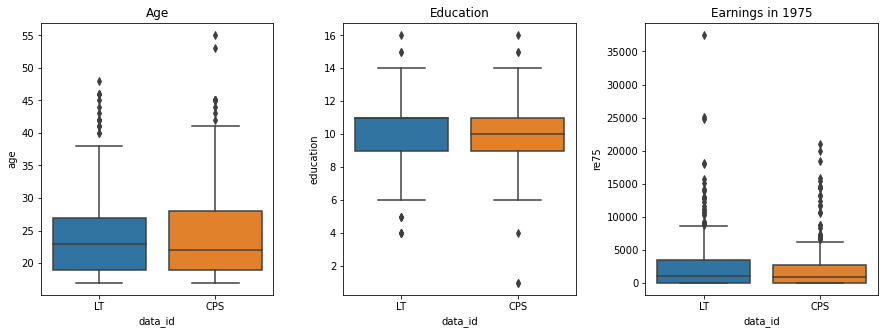

In [48]:
# Show boxplots
fn_boxplots(df = df_matched_treat, re74 = False)

In [49]:
# Propensity score matching with LaLonde and PSID
phat_GB_LT_PSID = fn_propensity_score(treat_id = 'LT', control_id = 'PSID', df = df, method = 'GB',
                                      param_grid = param_grid)

df_matched = fn_generate_df_matched(treat_id = 'LT', control_id = 'PSID', outcome = 'dif', df = df,
                                    prop = phat_GB_LT_PSID, n_neighbors = 1)

# Show averages by group
df_matched_treat = fn_generate_df_matched_treat(df_matched = df_matched, treat_id = 'LT')
fn_mean_by_group(df_matched_treat = df_matched_treat, treat_id = 'LT')

data_id                    LT         PSID
treat                1.000000     0.000000
age                 24.626263    23.585859
education           10.380471    10.501684
black                0.801347     0.865320
hispanic             0.094276     0.067340
married              0.168350     0.161616
nodegree             0.730640     0.767677
re75              3066.098191  2369.193542
re78              5976.352024  6672.423098
dif               2910.253832  4303.229556
propensity_score     0.673230     0.666753

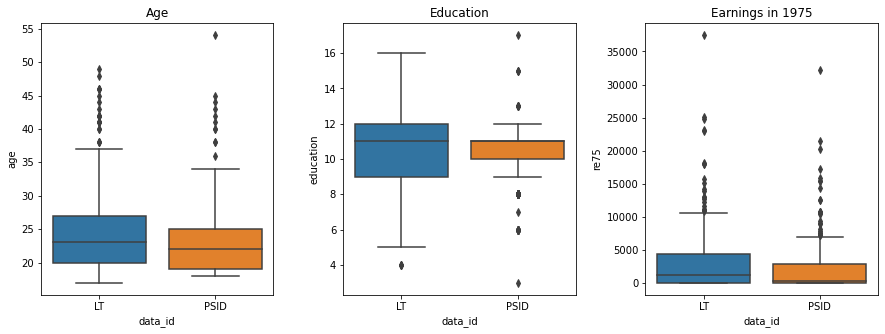

In [50]:
# Show boxplots
fn_boxplots(df = df_matched_treat, re74 = False)

Now we can see that the distribution of matched samples is quite similar to treatment group of LaLonde dataset. These observations imply that Gradient Boosting would be more appropriate for propensity score estimation than Random Forest in this application.  

The following tables and figures compare the distributions of matched samples with DW subset. The implications are basically the same as those of LaLonde dataset.

In [51]:
# Propensity score matching with DW and CPS
phat_GB_DWT_CPS = fn_propensity_score(treat_id = 'DWT', control_id = 'CPS', df = df, method = 'GB',
                                      param_grid = param_grid)

df_matched = fn_generate_df_matched(treat_id = 'DWT', control_id = 'CPS', outcome = 'dif', df = df,
                                    prop = phat_GB_DWT_CPS, n_neighbors = 1)

# Show averages by group
df_matched_treat = fn_generate_df_matched_treat(df_matched = df_matched, treat_id = 'DWT')
fn_mean_by_group(df_matched_treat = df_matched_treat, treat_id = 'DWT')

data_id                   CPS          DWT
treat                0.000000     1.000000
age                 25.897143    25.845714
education           10.594286    10.274286
black                0.937143     0.880000
hispanic             0.011429     0.057143
married              0.160000     0.165714
nodegree             0.685714     0.731429
re75              1007.286712  1337.253426
re78              4641.243593  6068.698316
re74              2754.773941  1783.137667
dif               3633.956881  4731.444890
propensity_score     0.399330     0.400717

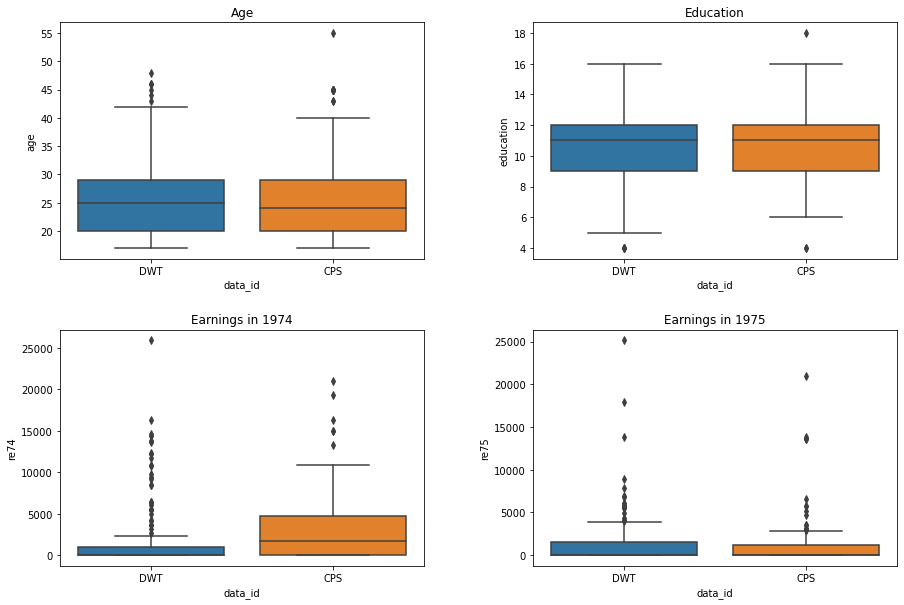

In [52]:
# Show boxplots
fn_boxplots(df = df_matched_treat, re74 = True)

In [53]:
# Propensity score matching with DW and PSID
phat_GB_DWT_PSID = fn_propensity_score(treat_id = 'DWT', control_id = 'PSID', df = df, method = 'GB',
                                       param_grid = param_grid)

df_matched = fn_generate_df_matched(treat_id = 'DWT', control_id = 'PSID', outcome = 'dif', df = df,
                                    prop = phat_GB_DWT_PSID, n_neighbors = 1)

# Show averages by group
df_matched_treat = fn_generate_df_matched_treat(df_matched = df_matched, treat_id = 'DWT')
fn_mean_by_group(df_matched_treat = df_matched_treat, treat_id = 'DWT')

data_id                   DWT         PSID
treat                1.000000     0.000000
age                 25.816216    28.416216
education           10.345946     9.772973
black                0.843243     0.891892
hispanic             0.059459     0.021622
married              0.189189     0.189189
nodegree             0.708108     0.708108
re75              1532.055313  1109.496774
re78              6349.143502  3429.531788
re74              2095.573693  2428.399990
dif               4817.088189  2320.035014
propensity_score     0.400181     0.399242

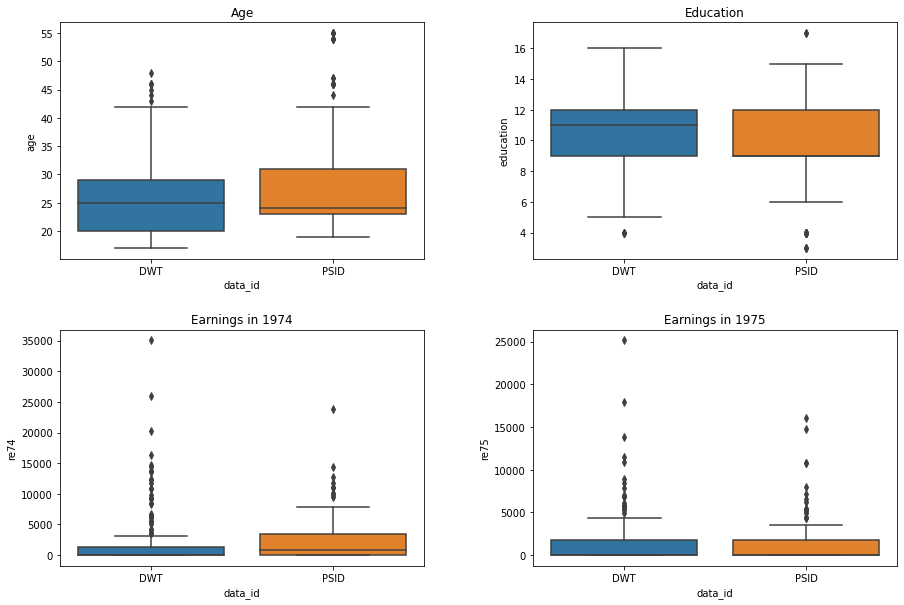

In [54]:
# Show boxplots
fn_boxplots(df = df_matched_treat, re74 = True)

#### 3.2.4 ATE and ATET Estimates by Propensity Score Matching

Now we estimate ATE and ATET by propensity score matching assuming different propensity score estimations, i.e., logistic regression, Random Forest and Gradient Boosting estimations.  
  
The following code actually generates all the results of propensity score matching, IPTW and doubly robust estimators. We have decided to compute all the estimates first to avoid estimating the propensity score repeatedly for different estimators. In this subsection, we focus on the results of propensity score matching.

In [55]:
# Compute all the ATE/ATET estimates for 3.2, 3.3 and 3.4
param_grid_p = {'n_estimators': [10, 50, 100, 500],
                'max_features': [2, 4, 6]}
param_grid_mu = {'n_estimators': [10, 50, 100, 500],
                 'max_features': [2, 4, 6]}

df_results = fn_generate_df_results(df = df, param_grid_p = param_grid_p, param_grid_mu = param_grid_mu)

100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [51:25<00:00, 1542.74s/it]


In [56]:
# Output the results as .csv file
df_results.to_csv('./results/prop_methods.csv', index = False)

We try different values of the number of matched samples (`Neighbors`) and caliper (`Caliper_Std`) to examine how the results would be affected by these parameters. We expect that there is a bias-variance trade-off here, i.e., bias would increase with `Neighbors` but variance would decrease with `Neighbors`. We also expect that setting an appropriate caliper will improve our estimation by avoiding matching the samples far from the treated samples. Note that `Caliper_Std` is measured in units of standard deviation of `propensity_score_logit`.

The following table shows the results of ATE and ATET estimates by propensity score matching.

In [57]:
# Show the results of propensity score matching with logistic regression
PSM_summary = fn_pick_results(df_results, method = 'PSM')
PSM_summary[(PSM_summary.Treatment == 'LT') & (PSM_summary.Est_Prop == 'logit')].reset_index(drop = True)

Outcome Treatment Control Method Est_Prop  Neighbors  Caliper_Std  \
0      dif        LT     CPS    PSM    logit        1.0          0.1   
1      dif        LT     CPS    PSM    logit        1.0          0.2   
2      dif        LT     CPS    PSM    logit        1.0          1.0   
3      dif        LT     CPS    PSM    logit       10.0          0.1   
4      dif        LT     CPS    PSM    logit       10.0          0.2   
5      dif        LT     CPS    PSM    logit       10.0          1.0   
6      dif        LT    PSID    PSM    logit        1.0          0.1   
7      dif        LT    PSID    PSM    logit        1.0          0.2   
8      dif        LT    PSID    PSM    logit        1.0          1.0   
9      dif        LT    PSID    PSM    logit       10.0          0.1   
10     dif        LT    PSID    PSM    logit       10.0          0.2   
11     dif        LT    PSID    PSM    logit       10.0          1.0   
12    re78        LT     CPS    PSM    logit        1.0          0.1   
13    re78        LT     CPS    PSM    logit        1.0          0.2   
14    re78        LT     CPS    PSM    logit        1.0          1.0   
15    re78        LT     CPS    PSM    logit       10.0          0.1   
16    re78        LT     CPS    PSM    logit       10.0          0.2   
17    re78        LT     CPS    PSM    logit       10.0          1.0   
18    re78        LT    PSID    PSM    logit        1.0          0.1   
19    re78        LT    PSID    PSM    logit        1.0          0.2   
20    re78        LT    PSID    PSM    logit        1.0          1.0   
21    re78        LT    PSID    PSM    logit       10.0          0.1   
22    re78        LT    PSID    PSM    logit       10.0          0.2   
23    re78        LT    PSID    PSM    logit       10.0          1.0   

            ATE         ATET  
0  -2122.159242  -142.154448  
1  -2122.159242  -142.154448  
2  -2122.159242  -142.154448  
3  -2096.141401  -445.395890  
4  -2354.402094  -445.395890  
5  -2424.962276  -445.395890  
6  -3103.368964  -693.000062  
7  -3094.999675  -669.771060  
8  -3094.999675  -669.771060  
9  -3534.327302  -418.806947  
10 -4016.039254  -423.599902  
11 -3812.946561  -547.026662  
12  -889.828448  -366.189363  
13  -889.828448  -366.189363  
14  -889.828448  -366.189363  
15  -841.607548  -572.825213  
16 -1002.031836  -572.825213  
17 -1107.750629  -572.825213  
18 -1596.799279 -1067.907741  
19 -1589.727296 -1043.150675  
20 -1589.727296 -1043.150675  
21 -2323.627876  -872.240185  
22 -2660.522784  -909.984619  
23 -2926.591437 -1096.360885

In [58]:
# Show the results of propensity score matching with logistic regression
PSM_summary[(PSM_summary.Treatment == 'DWT') & (PSM_summary.Est_Prop == 'logit')].reset_index(drop = True)

Outcome Treatment Control Method Est_Prop  Neighbors  Caliper_Std  \
0      dif       DWT     CPS    PSM    logit        1.0          0.1   
1      dif       DWT     CPS    PSM    logit        1.0          0.2   
2      dif       DWT     CPS    PSM    logit        1.0          1.0   
3      dif       DWT     CPS    PSM    logit       10.0          0.1   
4      dif       DWT     CPS    PSM    logit       10.0          0.2   
5      dif       DWT     CPS    PSM    logit       10.0          1.0   
6      dif       DWT    PSID    PSM    logit        1.0          0.1   
7      dif       DWT    PSID    PSM    logit        1.0          0.2   
8      dif       DWT    PSID    PSM    logit        1.0          1.0   
9      dif       DWT    PSID    PSM    logit       10.0          0.1   
10     dif       DWT    PSID    PSM    logit       10.0          0.2   
11     dif       DWT    PSID    PSM    logit       10.0          1.0   
12    re78       DWT     CPS    PSM    logit        1.0          0.1   
13    re78       DWT     CPS    PSM    logit        1.0          0.2   
14    re78       DWT     CPS    PSM    logit        1.0          1.0   
15    re78       DWT     CPS    PSM    logit       10.0          0.1   
16    re78       DWT     CPS    PSM    logit       10.0          0.2   
17    re78       DWT     CPS    PSM    logit       10.0          1.0   
18    re78       DWT    PSID    PSM    logit        1.0          0.1   
19    re78       DWT    PSID    PSM    logit        1.0          0.2   
20    re78       DWT    PSID    PSM    logit        1.0          1.0   
21    re78       DWT    PSID    PSM    logit       10.0          0.1   
22    re78       DWT    PSID    PSM    logit       10.0          0.2   
23    re78       DWT    PSID    PSM    logit       10.0          1.0   

            ATE         ATET  
0    582.927011   650.086686  
1    998.837388   650.086686  
2   1294.610131   650.086686  
3    862.229409  1554.425066  
4    892.014850  1554.425066  
5    713.821638  1554.425066  
6   -286.333803   776.036224  
7   -637.346074   776.036224  
8   -461.855669   776.036224  
9   -342.211753   283.489422  
10  -438.412090   253.016125  
11  -881.656491  -164.136740  
12   746.841283   758.581889  
13   995.147428   758.581889  
14  1199.540079   758.581889  
15   360.938778  1621.424712  
16   452.102683  1621.424712  
17    21.622360  1621.424712  
18  -420.169175   174.346387  
19  -587.236248   174.346387  
20  -129.761621   174.346387  
21  -632.250106  -238.985475  
22  -805.931255  -198.176984  
23 -1979.564286  -653.123780

The above tables show the results when the propensity score is estimated by logistic regression. Although the matching can apparently make treatment and control groups comparable, the estimates are neither robust nor accurate in general.  

For DW subset (latter table), the ATET estimate is relatively accurate when using CPS as a control group and matching multiple samples with one treated sample. However, the ATET estimate is not accurate in the other cases. The ATE estimates are almost always wrong.

For LaLonde dataset (former table), both ATE and ATET estimates are always negative, which implies that the propensity score matching is useless when exploring LaLonde dataset.

In [59]:
# Show the results of propensity score matching with Random Forest
PSM_summary[(PSM_summary.Treatment == 'LT') & (PSM_summary.Est_Prop == 'RF')].reset_index(drop = True)

Outcome Treatment Control Method Est_Prop  Neighbors  Caliper_Std  \
0      dif        LT     CPS    PSM       RF        1.0          0.1   
1      dif        LT     CPS    PSM       RF        1.0          0.2   
2      dif        LT     CPS    PSM       RF        1.0          1.0   
3      dif        LT     CPS    PSM       RF       10.0          0.1   
4      dif        LT     CPS    PSM       RF       10.0          0.2   
5      dif        LT     CPS    PSM       RF       10.0          1.0   
6      dif        LT    PSID    PSM       RF        1.0          0.1   
7      dif        LT    PSID    PSM       RF        1.0          0.2   
8      dif        LT    PSID    PSM       RF        1.0          1.0   
9      dif        LT    PSID    PSM       RF       10.0          0.1   
10     dif        LT    PSID    PSM       RF       10.0          0.2   
11     dif        LT    PSID    PSM       RF       10.0          1.0   
12    re78        LT     CPS    PSM       RF        1.0          0.1   
13    re78        LT     CPS    PSM       RF        1.0          0.2   
14    re78        LT     CPS    PSM       RF        1.0          1.0   
15    re78        LT     CPS    PSM       RF       10.0          0.1   
16    re78        LT     CPS    PSM       RF       10.0          0.2   
17    re78        LT     CPS    PSM       RF       10.0          1.0   
18    re78        LT    PSID    PSM       RF        1.0          0.1   
19    re78        LT    PSID    PSM       RF        1.0          0.2   
20    re78        LT    PSID    PSM       RF        1.0          1.0   
21    re78        LT    PSID    PSM       RF       10.0          0.1   
22    re78        LT    PSID    PSM       RF       10.0          0.2   
23    re78        LT    PSID    PSM       RF       10.0          1.0   

            ATE         ATET  
0   4241.322915   345.116638  
1   4612.199512   600.377703  
2   6623.494432  1357.259257  
3   4287.875690   610.524279  
4   4664.086816   879.699672  
5   5095.142940  1257.666296  
6  -2270.360667 -3348.770355  
7  -1283.515917 -2947.985851  
8   4266.720129   687.355290  
9  -2109.951508 -3187.907810  
10 -1834.401509 -3222.302233  
11   755.756554 -2446.916465  
12  3399.295409  4786.366744  
13  3190.354670  4717.643925  
14  3266.521048  4787.062807  
15  3445.081189  4990.532667  
16  3241.689407  4947.108853  
17  1737.898376  4657.670235  
18  1712.251553  2481.417167  
19  1567.726489  2764.734106  
20  2612.047244  4470.474870  
21  1984.187694  2607.768316  
22  1162.802392  2458.352373  
23  -406.340641  1314.749869

In [60]:
# Show the results of propensity score matching with Random Forest
PSM_summary[(PSM_summary.Treatment == 'DWT') & (PSM_summary.Est_Prop == 'RF')].reset_index(drop = True)

Outcome Treatment Control Method Est_Prop  Neighbors  Caliper_Std  \
0      dif       DWT     CPS    PSM       RF        1.0          0.1   
1      dif       DWT     CPS    PSM       RF        1.0          0.2   
2      dif       DWT     CPS    PSM       RF        1.0          1.0   
3      dif       DWT     CPS    PSM       RF       10.0          0.1   
4      dif       DWT     CPS    PSM       RF       10.0          0.2   
5      dif       DWT     CPS    PSM       RF       10.0          1.0   
6      dif       DWT    PSID    PSM       RF        1.0          0.1   
7      dif       DWT    PSID    PSM       RF        1.0          0.2   
8      dif       DWT    PSID    PSM       RF        1.0          1.0   
9      dif       DWT    PSID    PSM       RF       10.0          0.1   
10     dif       DWT    PSID    PSM       RF       10.0          0.2   
11     dif       DWT    PSID    PSM       RF       10.0          1.0   
12    re78       DWT     CPS    PSM       RF        1.0          0.1   
13    re78       DWT     CPS    PSM       RF        1.0          0.2   
14    re78       DWT     CPS    PSM       RF        1.0          1.0   
15    re78       DWT     CPS    PSM       RF       10.0          0.1   
16    re78       DWT     CPS    PSM       RF       10.0          0.2   
17    re78       DWT     CPS    PSM       RF       10.0          1.0   
18    re78       DWT    PSID    PSM       RF        1.0          0.1   
19    re78       DWT    PSID    PSM       RF        1.0          0.2   
20    re78       DWT    PSID    PSM       RF        1.0          1.0   
21    re78       DWT    PSID    PSM       RF       10.0          0.1   
22    re78       DWT    PSID    PSM       RF       10.0          0.2   
23    re78       DWT    PSID    PSM       RF       10.0          1.0   

            ATE         ATET  
0   4157.113379  3178.919208  
1   4572.784613  3308.448715  
2   6855.947862  3712.777021  
3   4211.188081  3280.189070  
4   4450.822742  3245.943528  
5   5068.027827  2881.397798  
6      4.125527  -455.727753  
7    785.691937   -77.783648  
8   4965.664214  3309.788784  
9    -31.898812  -814.930605  
10  -587.953012 -1507.584038  
11  1112.384621   146.533986  
12  3944.701062  5174.646639  
13  4016.314486  5308.881402  
14  4430.530164  5541.359169  
15  4023.427076  5254.335496  
16  3914.032806  5227.592748  
17  2652.121784  4696.892111  
18  2129.386076  2588.301476  
19  2516.844917  2886.907361  
20  3474.286325  5086.305245  
21  2202.901873  2211.640623  
22  1431.498596  1440.726625  
23    73.240660  1911.838974

The above tables show the results with Random Forest. The matching fails to generate accurate ATE and ATET estimates for both LaLonde dataset (former table) and DW subset (latter table). It is not surprising because Random Forest matches the samples that are not similar to each other at all as we have seen in 3.2.2.

In [61]:
# Show the results of propensity score matching with Gradient Boosting
PSM_summary[(PSM_summary.Treatment == 'LT') & (PSM_summary.Est_Prop == 'GB')].reset_index(drop = True)

Outcome Treatment Control Method Est_Prop  Neighbors  Caliper_Std  \
0      dif        LT     CPS    PSM       GB        1.0          0.1   
1      dif        LT     CPS    PSM       GB        1.0          0.2   
2      dif        LT     CPS    PSM       GB        1.0          1.0   
3      dif        LT     CPS    PSM       GB       10.0          0.1   
4      dif        LT     CPS    PSM       GB       10.0          0.2   
5      dif        LT     CPS    PSM       GB       10.0          1.0   
6      dif        LT    PSID    PSM       GB        1.0          0.1   
7      dif        LT    PSID    PSM       GB        1.0          0.2   
8      dif        LT    PSID    PSM       GB        1.0          1.0   
9      dif        LT    PSID    PSM       GB       10.0          0.1   
10     dif        LT    PSID    PSM       GB       10.0          0.2   
11     dif        LT    PSID    PSM       GB       10.0          1.0   
12    re78        LT     CPS    PSM       GB        1.0          0.1   
13    re78        LT     CPS    PSM       GB        1.0          0.2   
14    re78        LT     CPS    PSM       GB        1.0          1.0   
15    re78        LT     CPS    PSM       GB       10.0          0.1   
16    re78        LT     CPS    PSM       GB       10.0          0.2   
17    re78        LT     CPS    PSM       GB       10.0          1.0   
18    re78        LT    PSID    PSM       GB        1.0          0.1   
19    re78        LT    PSID    PSM       GB        1.0          0.2   
20    re78        LT    PSID    PSM       GB        1.0          1.0   
21    re78        LT    PSID    PSM       GB       10.0          0.1   
22    re78        LT    PSID    PSM       GB       10.0          0.2   
23    re78        LT    PSID    PSM       GB       10.0          1.0   

            ATE         ATET  
0   -337.008420 -1019.962234  
1   -337.552305  -999.395703  
2   -359.019855 -1147.542430  
3  -1289.283517  -511.724553  
4  -2211.720832  -554.810328  
5  -3300.179653  -511.161405  
6  -5028.442449  -959.562942  
7  -5450.444965  -915.314388  
8  -5313.204987  -367.736119  
9  -4116.378484 -1915.652944  
10 -3684.603150 -1914.781862  
11 -4611.129755 -1676.157565  
12 -1146.042003  -538.107423  
13 -1137.915716  -502.674157  
14 -1139.976147  -519.379822  
15 -1161.980756   -14.938987  
16 -1194.545135   -64.099587  
17 -1301.756697    72.052689  
18 -3734.843599  -251.600946  
19 -4130.937114  -206.196606  
20 -4224.317797   350.079736  
21 -4174.422516 -1283.342521  
22 -4482.415107 -1366.728744  
23 -5334.585714 -1118.566554

In [62]:
# Show the results of propensity score matching with Gradient Boosting
PSM_summary[(PSM_summary.Treatment == 'DWT') & (PSM_summary.Est_Prop == 'GB')].reset_index(drop = True)

Outcome Treatment Control Method Est_Prop  Neighbors  Caliper_Std  \
0      dif       DWT     CPS    PSM       GB        1.0          0.1   
1      dif       DWT     CPS    PSM       GB        1.0          0.2   
2      dif       DWT     CPS    PSM       GB        1.0          1.0   
3      dif       DWT     CPS    PSM       GB       10.0          0.1   
4      dif       DWT     CPS    PSM       GB       10.0          0.2   
5      dif       DWT     CPS    PSM       GB       10.0          1.0   
6      dif       DWT    PSID    PSM       GB        1.0          0.1   
7      dif       DWT    PSID    PSM       GB        1.0          0.2   
8      dif       DWT    PSID    PSM       GB        1.0          1.0   
9      dif       DWT    PSID    PSM       GB       10.0          0.1   
10     dif       DWT    PSID    PSM       GB       10.0          0.2   
11     dif       DWT    PSID    PSM       GB       10.0          1.0   
12    re78       DWT     CPS    PSM       GB        1.0          0.1   
13    re78       DWT     CPS    PSM       GB        1.0          0.2   
14    re78       DWT     CPS    PSM       GB        1.0          1.0   
15    re78       DWT     CPS    PSM       GB       10.0          0.1   
16    re78       DWT     CPS    PSM       GB       10.0          0.2   
17    re78       DWT     CPS    PSM       GB       10.0          1.0   
18    re78       DWT    PSID    PSM       GB        1.0          0.1   
19    re78       DWT    PSID    PSM       GB        1.0          0.2   
20    re78       DWT    PSID    PSM       GB        1.0          1.0   
21    re78       DWT    PSID    PSM       GB       10.0          0.1   
22    re78       DWT    PSID    PSM       GB       10.0          0.2   
23    re78       DWT    PSID    PSM       GB       10.0          1.0   

             ATE         ATET  
0    2577.779959   263.102656  
1    2505.060637   227.885965  
2    2502.720640   223.290165  
3     153.221219  1144.790506  
4     603.802920  1105.439666  
5     287.699264  1141.155189  
6     -58.634960 -5464.929831  
7     792.901028 -5307.852600  
8    -964.812778 -5273.373155  
9   -1708.640503 -1122.921778  
10  -1310.024332  -961.598052  
11  -1359.494244 -1657.219481  
12   -138.896898   823.137404  
13    -27.182626   801.311721  
14    -26.734478   799.897285  
15   -547.303359  1441.323674  
16   -215.555636  1414.241530  
17   -222.001663  1408.619669  
18  -2925.637590 -5599.025584  
19  -2157.466984 -5455.552577  
20  -8252.526843 -5411.243634  
21  -3102.661622  -894.666154  
22  -2452.289790  -717.401166  
23 -10312.566275 -1398.965143

The above tables show the results with Gradient Boosting. Although the matching makes distributions of treatment and control groups somewhat similar in 3.2.3, the estimates turn out to be not so accurate unfortunately. Some of the ATET estimates are relatively close to benchmarks, but the results are not robust. In particular, the estimates are totally wrong for LaLonde dataset.

Overall, we have to say that propensity score matching would not improve our estimates. In particular, it generates totally wrong ATE and ATET estimates in the case of LaLonde dataset. Our results somehow support Smith and Todd (2005) in the sense that propensity score matching does not necessarily perform well.

### 3.3 Inverse Probability of Treatment Weighted (IPTW) Estimator

The IPTW estimator weights outcome values based on propensity score estimates. In the case of ATE estimation, the estimator uses $1/\hat{p}(X_i)$ as weights for treated samples and $1/(1 - \hat{p}(X_i))$ for controlled samples. That way, we can estimate the ATE by

$$
\hat{\tau}_{ATE} = \frac{1}{n} \sum_{i = 1}^n \frac{D_i Y_i}{\hat{p}(X_i)} - \frac{1}{n} \sum_{i = 1}^n \frac{(1 - D_i) Y_i}{1 - \hat{p}(X_i)}.
$$

In the case of ATET, the weights become $1$ for treated samples and $\hat{p}(X_i)/(1 - \hat{p}(X_i))$ for controlled samples:

$$
\hat{\tau}_{ATET} = \frac{1}{n_1} \sum_{i = 1}^n \left(D_i Y_i - \frac{\hat{p}(X_i)(1 - D_i) Y_i}{1 - \hat{p}(X_i)} \right).
$$

By weighting based on the inverse of the propensity score, we are intuitively giving a high weight on treated samples that look like controlled samples (i.e., $\hat{p}(X_i)$ is small while $D_i = 1$) and controlled samples that look like treated samples (i.e., $\hat{p}(X_i)$ is large while $D_i = 0$). That way, we can mitigate systematic differences in characteristics between experimental treatment and nonexperimental control groups just like propensity score matching.

Below we obtain the IPTW estimator assuming the same propensity score estimates as we have obtained for matching. That is, we estimate $p(X_i)$ by logistic regression, Random Forest and Gradient Boosting.

#### 3.3.1 Logistic Regression

The following table shows the resulting values of ATE/ATET estimates by IPTW estimation when $\hat{p}(X_i)$ is estimated by logistic regression.

In [63]:
# Show the results of IPTW with logistic regression
IPTW_summary = fn_pick_results(df_results, method = 'IPTW')
IPTW_summary[IPTW_summary.Est_Prop == 'logit'].reset_index(drop = True)

Outcome Treatment Control Method Est_Prop          ATE         ATET
0     dif        LT     CPS   IPTW    logit -2779.761998  -593.662732
1     dif        LT    PSID   IPTW    logit -5954.985771  -269.611850
2     dif       DWT     CPS   IPTW    logit  -192.714901  1215.922811
3     dif       DWT    PSID   IPTW    logit -1076.628815   775.573925
4    re78        LT     CPS   IPTW    logit -1634.390493  -498.001979
5    re78        LT    PSID   IPTW    logit -2196.506472  -642.359816
6    re78       DWT     CPS   IPTW    logit -1008.058240   903.538102
7    re78       DWT    PSID   IPTW    logit -2806.561656   261.043708

The estimates are generally inaccurate and sensitive to modeling specifications. Just as in the case of propensity score matching, the ATET estimate for DW subset is relatively accurate when CPS is used as a control group. However, since the results are not robust, we have to say that the IPTW estimator with logistic regression could not replicate experimental results.

#### 3.3.2 Random Forest Classification

The following table shows the IPTW estimates of ATE and ATET assuming propensity score estimates obtained by Random Forest.

In [64]:
# Show the results of IPTW with Random Forest
IPTW_summary[IPTW_summary.Est_Prop == 'RF'].reset_index(drop = True)

Outcome Treatment Control Method Est_Prop          ATE         ATET
0     dif        LT     CPS   IPTW       RF  -982.659291  1855.238450
1     dif        LT    PSID   IPTW       RF -1875.629566  1669.013934
2     dif       DWT     CPS   IPTW       RF  -704.027535  3486.474584
3     dif       DWT    PSID   IPTW       RF -1320.886662  3507.766844
4    re78        LT     CPS   IPTW       RF -4106.102040  4162.645597
5    re78        LT    PSID   IPTW       RF -5656.049848  4209.871315
6    re78       DWT     CPS   IPTW       RF -2984.165810  4596.775675
7    re78       DWT    PSID   IPTW       RF -4958.626975  4708.800995

The estimates are extremely sensitive to the modeling specifications and none of them generates estimates close to benchmarks. This is quite understandable because Random Forest fails to make treatment and control groups comparable (see 3.2.2).

#### 3.3.3 Gradient Boosting Classification

The following table presents the IPTW estimates when we estimate $\hat{p}(X_i)$ by Gradient Boosting.

In [65]:
# Show the results of IPTW with Gradient Boosting
IPTW_summary[IPTW_summary.Est_Prop == 'GB'].reset_index(drop = True)

Outcome Treatment Control Method Est_Prop           ATE         ATET
0     dif        LT     CPS   IPTW       GB  -2493.438851  -392.709011
1     dif        LT    PSID   IPTW       GB  -3143.190227  -261.639983
2     dif       DWT     CPS   IPTW       GB   -247.006057  1542.335937
3     dif       DWT    PSID   IPTW       GB  -1676.929992  2031.526529
4    re78        LT     CPS   IPTW       GB  -1512.281473   268.570410
5    re78        LT    PSID   IPTW       GB  -8222.270951   343.746569
6    re78       DWT     CPS   IPTW       GB    174.411658  1767.955392
7    re78       DWT    PSID   IPTW       GB -18634.404016 -4547.221612

In general, IPTW estimates based on Gradient Boosting are not so accurate. Again, they can be relatively accurate as an ATET estimate when the treatment group of DW subset and CPS are compared, but the results are not robust at all.  
  
Considering these results, we conclude that IPTW estimator would not improve our estimates of ATE and ATET when the propensity score is estimated by logistic regression, Random Forest or Gradient Boosting.

### 3.4 Doubly Robust Estimator

The doubly robust estimator combines propensity score weighting and imputation regression methods. Specifically, the ATE estimate is given by

$$
\hat{\tau}_{ATE} = \frac{1}{n} \sum_{i = 1}^n \left( \frac{D_i(Y_i - \hat{\mu}_1 (X_i))}{\hat{p}(X_i)} + \hat{\mu}_1 (X_i) \right) - \frac{1}{n} \sum_{i = 1}^n \left( \frac{(1 - D_i)(Y_i - \hat{\mu}_0 (X_i))}{1 - \hat{p}(X_i)} + \hat{\mu}_0 (X_i) \right).
$$

The estimator is known to be "doubly robust" in the sense that it is consistent if either $\hat{p}(X_i)$ or $\hat{\mu}_d (X_i), d \in \{0,1 \}$ is consistent. Thus, we expect that the doubly robust estimator can take advantages of both regression and propensity score methods and improve our ATE estimates.  

Mercatanti and Li (2014) proposed the estimator for ATET as follows. According to them, it can be proved that $\hat{\tau}_{ATET}$ is a consistent estimator for ATET if either $\hat{p}(X_i)$ or $\hat{\mu}_0 (X_i)$ is consistent:

$$
\hat{\tau}_{ATET} = \frac{1}{n_1} \sum_{i = 1}^n \left( D_i Y_i - \frac{\hat{p}(X_i)(1 - D_i)Y_i + (D_i - \hat{p}(X_i))\hat{\mu}_0 (X_i)}{1 - \hat{p}(X_i)} \right).
$$

We use the same propensity score estimates as in 3.2 and 3.3 here. For estimation of $\mu_d (X_i), d \in \{0,1 \}$, we use machine learning methods, Random Forest and Gradient Boosting. What we do here is basically the same as in 3.1. That is, we fit $Y = \mu_D (X) = f(D, X)$ using Random Forest or Gradient Boosting and estimate $\mu_d (X_i)$ by $\hat{\mu}_d (X_i) = \hat{f}(d, X_i), d \in \{0,1 \}$.

#### 3.4.1 Impuations by Random Forest Regression

First, we estimate $\mu_d (X_i), d \in \{0,1 \}$ by Random Forest. For propensity score, we keep using the three estimates by logistic regression, Random Forest and Gradient Boosting. The following tables present the results of ATE and ATET estimates.

In [66]:
# Show the results of doubly robust estimator with Random Forest
DR_summary = fn_pick_results(df_results, method = 'DR')
DR_summary[(DR_summary.Treatment == 'LT') & (DR_summary.Est_Imput == 'RF')].reset_index(drop = True)

Outcome Treatment Control Method Est_Prop Est_Imput          ATE  \
0      dif        LT     CPS     DR    logit        RF -1021.042395   
1      dif        LT     CPS     DR       RF        RF  -220.785766   
2      dif        LT     CPS     DR       GB        RF  -801.541522   
3      dif        LT    PSID     DR    logit        RF -2920.454054   
4      dif        LT    PSID     DR       RF        RF -2571.618159   
5      dif        LT    PSID     DR       GB        RF -2662.281403   
6     re78        LT     CPS     DR    logit        RF  -711.279809   
7     re78        LT     CPS     DR       RF        RF  -178.551213   
8     re78        LT     CPS     DR       GB        RF  -894.718535   
9     re78        LT    PSID     DR    logit        RF -2787.198016   
10    re78        LT    PSID     DR       RF        RF -3322.986693   
11    re78        LT    PSID     DR       GB        RF -4138.174327   

           ATET  
0   -105.369648  
1   -224.900514  
2   -289.522390  
3  -1194.089637  
4  -1738.394704  
5  -1377.593973  
6   -152.167763  
7   -290.116633  
8   -376.504480  
9  -1354.539849  
10 -2014.382120  
11 -1691.397923

In [67]:
# Show the results of doubly robust estimator with Random Forest
DR_summary[(DR_summary.Treatment == 'DWT') & (DR_summary.Est_Imput == 'RF')].reset_index(drop = True)

Outcome Treatment Control Method Est_Prop Est_Imput          ATE  \
0      dif       DWT     CPS     DR    logit        RF   884.163114   
1      dif       DWT     CPS     DR       RF        RF  1416.888321   
2      dif       DWT     CPS     DR       GB        RF   533.579697   
3      dif       DWT    PSID     DR    logit        RF  -315.365547   
4      dif       DWT    PSID     DR       RF        RF  -685.804462   
5      dif       DWT    PSID     DR       GB        RF   606.304922   
6     re78       DWT     CPS     DR    logit        RF  1058.357602   
7     re78       DWT     CPS     DR       RF        RF  1382.484539   
8     re78       DWT     CPS     DR       GB        RF   622.441941   
9     re78       DWT    PSID     DR    logit        RF  -608.596244   
10    re78       DWT    PSID     DR       RF        RF -1674.569733   
11    re78       DWT    PSID     DR       GB        RF -4776.742434   

           ATET  
0   1426.718596  
1   1298.625217  
2   1172.696024  
3   -128.201575  
4   -176.452298  
5    243.315544  
6   1383.295656  
7   1224.363854  
8   1106.353257  
9   -406.516490  
10  -738.368435  
11  -641.546987

The results are similar to those of propensity score matching and IPTW estimator. That is, the ATET estimates are relatively accurate when we compare treatment group of DW subset and CPS, but they are not robust to the case of PSID. For LaLonde dataset (former table), all the estimates of ATE and ATET are negative, which implies that doubly robust estimator does not work well with LaLonde dataset.

#### 3.4.2 Impuations by Gradient Boosting Regression

Next, we estimate $\mu_d (X_i), d \in \{0,1 \}$ by Gradient Boosting. The following tables show the results.

In [68]:
# Show the results of doubly robust estimator with Gradient Boosting
DR_summary[(DR_summary.Treatment == 'LT') & (DR_summary.Est_Imput == 'GB')].reset_index(drop = True)

Outcome Treatment Control Method Est_Prop Est_Imput          ATE  \
0      dif        LT     CPS     DR    logit        GB  -944.079150   
1      dif        LT     CPS     DR       RF        GB  -785.626397   
2      dif        LT     CPS     DR       GB        GB -1475.448121   
3      dif        LT    PSID     DR    logit        GB -5534.111038   
4      dif        LT    PSID     DR       RF        GB -1226.834577   
5      dif        LT    PSID     DR       GB        GB -2364.572772   
6     re78        LT     CPS     DR    logit        GB -1301.161486   
7     re78        LT     CPS     DR       RF        GB  -712.623865   
8     re78        LT     CPS     DR       GB        GB -1414.446595   
9     re78        LT    PSID     DR    logit        GB -3498.468897   
10    re78        LT    PSID     DR       RF        GB -2817.074464   
11    re78        LT    PSID     DR       GB        GB -3901.751434   

           ATET  
0   -239.712187  
1   -407.097207  
2   -549.156471  
3   -385.631801  
4   -835.337521  
5  -1061.396207  
6   -276.235698  
7   -454.736118  
8   -577.277607  
9   -827.731975  
10 -2066.934012  
11 -1523.330967

In [69]:
# Show the results of doubly robust estimator with Gradient Boosting
DR_summary[(DR_summary.Treatment == 'DWT') & (DR_summary.Est_Imput == 'GB')].reset_index(drop = True)

Outcome Treatment Control Method Est_Prop Est_Imput          ATE  \
0      dif       DWT     CPS     DR    logit        GB   708.201824   
1      dif       DWT     CPS     DR       RF        GB  1189.005218   
2      dif       DWT     CPS     DR       GB        GB  -138.808639   
3      dif       DWT    PSID     DR    logit        GB  -301.972178   
4      dif       DWT    PSID     DR       RF        GB  -197.865221   
5      dif       DWT    PSID     DR       GB        GB   -83.231229   
6     re78       DWT     CPS     DR    logit        GB   507.524501   
7     re78       DWT     CPS     DR       RF        GB  1046.999867   
8     re78       DWT     CPS     DR       GB        GB  -290.984801   
9     re78       DWT    PSID     DR    logit        GB  -380.059913   
10    re78       DWT    PSID     DR       RF        GB  -664.465562   
11    re78       DWT    PSID     DR       GB        GB -3230.463011   

           ATET  
0   1284.553952  
1   1111.456337  
2    999.010109  
3    734.328368  
4   1080.209754  
5   1019.996122  
6   1272.931510  
7   1098.403176  
8    946.728090  
9    553.123384  
10  -673.495966  
11  -667.361581

Unfortunately, doubly robust estimator with Gradient Boosting does not generate ATE or ATET estimates that are close to experimental ones. Even when the treatment group of DW subset and CPS are compared, it tends to underestimate ATET compared to Random Forest.  

Overall, doubly robust estimator does not improve our nonexperimental estimates of ATE and ATET, which implies that **both of** our estimates of propensity score $\hat{p}(X_i)$ **and** conditional mean $\hat{\mu}_d(X_i)$ might be incorrect.

## 4. Findings

In this section, we summarize what we have found in this project, showing some of the results we have got again.

### 4.1 Linear Regression

The following tables show the results of ATE and ATET estimates by linear regression model. Remember that, in the linear regression model, ATE and ATET estimates would be the same as long as the fixed coefficients are assumed.

In [70]:
# Show the results of linear regression
df_table1 = pd.concat([reg_summary_dif[reg_summary_dif.Treatment == 'LT'],
                       reg_summary_re78[reg_summary_re78.Treatment == 'LT']], axis = 0).reset_index(drop = True)
df_table1

Outcome Treatment Control  Without control      With age  With all controls
0     dif        LT      LC       846.888287    856.910955         800.535314
1     dif        LT     CPS      1714.397705    195.174602        -999.609429
2     dif        LT    PSID       419.670577   -749.207210       -1347.796366
3    re78        LT      LC       886.303722    881.739626         800.535314
4    re78        LT     CPS     -8870.307627  -7172.308044        -999.609429
5    re78        LT    PSID    -15577.568900 -13267.657059       -1347.796366

In [71]:
# Show the results of linear regression
df_table2 = pd.concat([reg_summary_dif[reg_summary_dif.Treatment == 'DWT'],
                       reg_summary_re78[reg_summary_re78.Treatment == 'DWT']], axis = 0).reset_index(drop = True)
df_table2

Outcome Treatment Control  Without control      With age  With all controls
0     dif       DWT     DWC      1529.196083   1516.996931        1636.108327
1     dif       DWT     CPS      3621.232061   2383.311533         622.547024
2     dif       DWT    PSID      2326.504934   1256.927930         455.570948
3    re78       DWT     DWC      1794.342382   1736.057724        1636.108327
4    re78       DWT     CPS     -8497.516148  -7274.306837         622.547024
5    re78       DWT    PSID    -15204.777421 -13268.950367         455.570948

The experimental ATE/ATET estimates are about 800&ndash;900 for LaLonde dataset and 1,500&ndash;1,800 for DW subset, considering different specifications and outcome variables.

The linear regression with nonexperimental data fails to generate similar estimates to experimental ones for both LaLonde dataset and DW subset. In addition, the nonexperimental estimates are very sensitive to the modeling specifications such as outcome variables, covariates and control groups. The column of `With all controls` should be identical between outcomes of `dif` and `re78` by design. However, the other columns show totally different values across different outcomes when nonexperimental data are used. The ATE/ATET estimates greatly differ across different covariates and different control groups (i.e., CPS or PSID).  

Overall, we conclude that linear regression is inaccurate and sensitive to different modeling specifications when we use nonexperimental data. This is roughly consistent with the conclusion of LaLonde (1986).

### 4.2 Random Forest and Gradient Boosting Regressions

The following tables show the results of ATE and ATET that are estimated by Random Forest and Gradient Boosting regressions.

In [72]:
# Show the results of Random Forest regression
df_table3 = RF_summary[RF_summary.Treatment == 'LT'].reset_index(drop = True)
df_table3

Outcome Treatment Control      Method Est_Imput          ATE         ATET
0     dif        LT      LC  Regression        RF   840.597285   661.812697
1     dif        LT     CPS  Regression        RF -4152.374393  -280.294032
2     dif        LT    PSID  Regression        RF -1989.601305 -1310.609442
3    re78        LT      LC  Regression        RF   878.072534   784.405159
4    re78        LT     CPS  Regression        RF -3020.025383  -307.202727
5    re78        LT    PSID  Regression        RF -6110.520853 -1680.443995

In [73]:
# Show the results of Random Forest regression
df_table4 = RF_summary[RF_summary.Treatment == 'DWT'].reset_index(drop = True)
df_table4

Outcome Treatment Control      Method Est_Imput          ATE         ATET
0     dif       DWT     DWC  Regression        RF  1461.802766  1514.054702
1     dif       DWT     CPS  Regression        RF -1119.575317  1197.687076
2     dif       DWT    PSID  Regression        RF    10.739112  -219.428083
3    re78       DWT     DWC  Regression        RF  1504.468808  1568.285453
4    re78       DWT     CPS  Regression        RF  -873.916539  1136.545393
5    re78       DWT    PSID  Regression        RF -4567.665416  -789.320493

In [74]:
# Show the results of Gradient Boosting regression
df_table5 = GB_summary[GB_summary.Treatment == 'LT'].reset_index(drop = True)
df_table5

Outcome Treatment Control      Method Est_Imput          ATE         ATET
0     dif        LT      LC  Regression        GB   556.496136   611.985555
1     dif        LT     CPS  Regression        GB -4321.463915  -591.669821
2     dif        LT    PSID  Regression        GB    23.565776   -32.876449
3    re78        LT      LC  Regression        GB   529.687722   588.058800
4    re78        LT     CPS  Regression        GB -4327.258744  -899.303045
5    re78        LT    PSID  Regression        GB -6383.741218 -1972.777983

In [75]:
# Show the results of Gradient Boosting regression
df_table6 = GB_summary[GB_summary.Treatment == 'DWT'].reset_index(drop = True)
df_table6

Outcome Treatment Control      Method Est_Imput          ATE         ATET
0     dif       DWT     DWC  Regression        GB  1062.094593  1157.052485
1     dif       DWT     CPS  Regression        GB -1917.804119  1094.496193
2     dif       DWT    PSID  Regression        GB   110.837982  1617.855773
3    re78       DWT     DWC  Regression        GB  1056.690317  1163.503599
4    re78       DWT     CPS  Regression        GB -1088.168411   679.754935
5    re78       DWT    PSID  Regression        GB -2120.980991 -1367.647377

The main finding is that we fail to replicate the experimental results with nonexperimental data. Although we could get relatively reliable estimates of ATET with DW subset, the estimates are sensitive to the choice of dependent variables and control groups. Even worse, these machine learning methods tend to generate lower estimates **with experimental data** than in linear regression, especially in the case of Gradient Boosting regression. Since linear regression would generate an unbiased estimate for ATE/ATET theoretically, this result implies that there might be a systematic downward bias in our Gradient Boosting regression estimator.

### 4.3 Propensity Score Matching

The following tables show the results of ATE/ATET estimates by propensity score matching where we use logistic regression to estimate the propensity score.

In [76]:
# Show the results of propensity score matching by logistic regression
df_table7 = PSM_summary[(PSM_summary.Treatment == 'LT') & (PSM_summary.Est_Prop == 'logit')].reset_index(drop = True)
df_table7

Outcome Treatment Control Method Est_Prop  Neighbors  Caliper_Std  \
0      dif        LT     CPS    PSM    logit        1.0          0.1   
1      dif        LT     CPS    PSM    logit        1.0          0.2   
2      dif        LT     CPS    PSM    logit        1.0          1.0   
3      dif        LT     CPS    PSM    logit       10.0          0.1   
4      dif        LT     CPS    PSM    logit       10.0          0.2   
5      dif        LT     CPS    PSM    logit       10.0          1.0   
6      dif        LT    PSID    PSM    logit        1.0          0.1   
7      dif        LT    PSID    PSM    logit        1.0          0.2   
8      dif        LT    PSID    PSM    logit        1.0          1.0   
9      dif        LT    PSID    PSM    logit       10.0          0.1   
10     dif        LT    PSID    PSM    logit       10.0          0.2   
11     dif        LT    PSID    PSM    logit       10.0          1.0   
12    re78        LT     CPS    PSM    logit        1.0          0.1   
13    re78        LT     CPS    PSM    logit        1.0          0.2   
14    re78        LT     CPS    PSM    logit        1.0          1.0   
15    re78        LT     CPS    PSM    logit       10.0          0.1   
16    re78        LT     CPS    PSM    logit       10.0          0.2   
17    re78        LT     CPS    PSM    logit       10.0          1.0   
18    re78        LT    PSID    PSM    logit        1.0          0.1   
19    re78        LT    PSID    PSM    logit        1.0          0.2   
20    re78        LT    PSID    PSM    logit        1.0          1.0   
21    re78        LT    PSID    PSM    logit       10.0          0.1   
22    re78        LT    PSID    PSM    logit       10.0          0.2   
23    re78        LT    PSID    PSM    logit       10.0          1.0   

            ATE         ATET  
0  -2122.159242  -142.154448  
1  -2122.159242  -142.154448  
2  -2122.159242  -142.154448  
3  -2096.141401  -445.395890  
4  -2354.402094  -445.395890  
5  -2424.962276  -445.395890  
6  -3103.368964  -693.000062  
7  -3094.999675  -669.771060  
8  -3094.999675  -669.771060  
9  -3534.327302  -418.806947  
10 -4016.039254  -423.599902  
11 -3812.946561  -547.026662  
12  -889.828448  -366.189363  
13  -889.828448  -366.189363  
14  -889.828448  -366.189363  
15  -841.607548  -572.825213  
16 -1002.031836  -572.825213  
17 -1107.750629  -572.825213  
18 -1596.799279 -1067.907741  
19 -1589.727296 -1043.150675  
20 -1589.727296 -1043.150675  
21 -2323.627876  -872.240185  
22 -2660.522784  -909.984619  
23 -2926.591437 -1096.360885

In [77]:
# Show the results of propensity score matching by logistic regression
df_table8 = PSM_summary[(PSM_summary.Treatment == 'DWT') & (PSM_summary.Est_Prop == 'logit')].reset_index(drop = True)
df_table8

Outcome Treatment Control Method Est_Prop  Neighbors  Caliper_Std  \
0      dif       DWT     CPS    PSM    logit        1.0          0.1   
1      dif       DWT     CPS    PSM    logit        1.0          0.2   
2      dif       DWT     CPS    PSM    logit        1.0          1.0   
3      dif       DWT     CPS    PSM    logit       10.0          0.1   
4      dif       DWT     CPS    PSM    logit       10.0          0.2   
5      dif       DWT     CPS    PSM    logit       10.0          1.0   
6      dif       DWT    PSID    PSM    logit        1.0          0.1   
7      dif       DWT    PSID    PSM    logit        1.0          0.2   
8      dif       DWT    PSID    PSM    logit        1.0          1.0   
9      dif       DWT    PSID    PSM    logit       10.0          0.1   
10     dif       DWT    PSID    PSM    logit       10.0          0.2   
11     dif       DWT    PSID    PSM    logit       10.0          1.0   
12    re78       DWT     CPS    PSM    logit        1.0          0.1   
13    re78       DWT     CPS    PSM    logit        1.0          0.2   
14    re78       DWT     CPS    PSM    logit        1.0          1.0   
15    re78       DWT     CPS    PSM    logit       10.0          0.1   
16    re78       DWT     CPS    PSM    logit       10.0          0.2   
17    re78       DWT     CPS    PSM    logit       10.0          1.0   
18    re78       DWT    PSID    PSM    logit        1.0          0.1   
19    re78       DWT    PSID    PSM    logit        1.0          0.2   
20    re78       DWT    PSID    PSM    logit        1.0          1.0   
21    re78       DWT    PSID    PSM    logit       10.0          0.1   
22    re78       DWT    PSID    PSM    logit       10.0          0.2   
23    re78       DWT    PSID    PSM    logit       10.0          1.0   

            ATE         ATET  
0    582.927011   650.086686  
1    998.837388   650.086686  
2   1294.610131   650.086686  
3    862.229409  1554.425066  
4    892.014850  1554.425066  
5    713.821638  1554.425066  
6   -286.333803   776.036224  
7   -637.346074   776.036224  
8   -461.855669   776.036224  
9   -342.211753   283.489422  
10  -438.412090   253.016125  
11  -881.656491  -164.136740  
12   746.841283   758.581889  
13   995.147428   758.581889  
14  1199.540079   758.581889  
15   360.938778  1621.424712  
16   452.102683  1621.424712  
17    21.622360  1621.424712  
18  -420.169175   174.346387  
19  -587.236248   174.346387  
20  -129.761621   174.346387  
21  -632.250106  -238.985475  
22  -805.931255  -198.176984  
23 -1979.564286  -653.123780

When logistic regression is used, ATE and ATET estimates are always negative with LaLonde dataset, regardless of the choices of control group, number of matched samples and caliper. On the other hand, ATET estimates with DW subset are almost always positive and some of them are close to benchmark estimates. This observation is somewhat consistent with Dehejia and Wahba (1999, 2002), but it is not robust to the choice of the maximum number of matched samples. The propensity score matching performs relatively well with DW subset and CPS, but it cannot be a general solution.

The following tables show the results when the propensity score is estimated by Random Forest.

In [78]:
# Show the results of propensity score matching by Random Forest
df_table9 = PSM_summary[(PSM_summary.Treatment == 'LT') & (PSM_summary.Est_Prop == 'RF')].reset_index(drop = True)
df_table9

Outcome Treatment Control Method Est_Prop  Neighbors  Caliper_Std  \
0      dif        LT     CPS    PSM       RF        1.0          0.1   
1      dif        LT     CPS    PSM       RF        1.0          0.2   
2      dif        LT     CPS    PSM       RF        1.0          1.0   
3      dif        LT     CPS    PSM       RF       10.0          0.1   
4      dif        LT     CPS    PSM       RF       10.0          0.2   
5      dif        LT     CPS    PSM       RF       10.0          1.0   
6      dif        LT    PSID    PSM       RF        1.0          0.1   
7      dif        LT    PSID    PSM       RF        1.0          0.2   
8      dif        LT    PSID    PSM       RF        1.0          1.0   
9      dif        LT    PSID    PSM       RF       10.0          0.1   
10     dif        LT    PSID    PSM       RF       10.0          0.2   
11     dif        LT    PSID    PSM       RF       10.0          1.0   
12    re78        LT     CPS    PSM       RF        1.0          0.1   
13    re78        LT     CPS    PSM       RF        1.0          0.2   
14    re78        LT     CPS    PSM       RF        1.0          1.0   
15    re78        LT     CPS    PSM       RF       10.0          0.1   
16    re78        LT     CPS    PSM       RF       10.0          0.2   
17    re78        LT     CPS    PSM       RF       10.0          1.0   
18    re78        LT    PSID    PSM       RF        1.0          0.1   
19    re78        LT    PSID    PSM       RF        1.0          0.2   
20    re78        LT    PSID    PSM       RF        1.0          1.0   
21    re78        LT    PSID    PSM       RF       10.0          0.1   
22    re78        LT    PSID    PSM       RF       10.0          0.2   
23    re78        LT    PSID    PSM       RF       10.0          1.0   

            ATE         ATET  
0   4241.322915   345.116638  
1   4612.199512   600.377703  
2   6623.494432  1357.259257  
3   4287.875690   610.524279  
4   4664.086816   879.699672  
5   5095.142940  1257.666296  
6  -2270.360667 -3348.770355  
7  -1283.515917 -2947.985851  
8   4266.720129   687.355290  
9  -2109.951508 -3187.907810  
10 -1834.401509 -3222.302233  
11   755.756554 -2446.916465  
12  3399.295409  4786.366744  
13  3190.354670  4717.643925  
14  3266.521048  4787.062807  
15  3445.081189  4990.532667  
16  3241.689407  4947.108853  
17  1737.898376  4657.670235  
18  1712.251553  2481.417167  
19  1567.726489  2764.734106  
20  2612.047244  4470.474870  
21  1984.187694  2607.768316  
22  1162.802392  2458.352373  
23  -406.340641  1314.749869

In [79]:
# Show the results of propensity score matching by Random Forest
df_table10 = PSM_summary[(PSM_summary.Treatment == 'DWT') & (PSM_summary.Est_Prop == 'RF')].reset_index(drop = True)
df_table10

Outcome Treatment Control Method Est_Prop  Neighbors  Caliper_Std  \
0      dif       DWT     CPS    PSM       RF        1.0          0.1   
1      dif       DWT     CPS    PSM       RF        1.0          0.2   
2      dif       DWT     CPS    PSM       RF        1.0          1.0   
3      dif       DWT     CPS    PSM       RF       10.0          0.1   
4      dif       DWT     CPS    PSM       RF       10.0          0.2   
5      dif       DWT     CPS    PSM       RF       10.0          1.0   
6      dif       DWT    PSID    PSM       RF        1.0          0.1   
7      dif       DWT    PSID    PSM       RF        1.0          0.2   
8      dif       DWT    PSID    PSM       RF        1.0          1.0   
9      dif       DWT    PSID    PSM       RF       10.0          0.1   
10     dif       DWT    PSID    PSM       RF       10.0          0.2   
11     dif       DWT    PSID    PSM       RF       10.0          1.0   
12    re78       DWT     CPS    PSM       RF        1.0          0.1   
13    re78       DWT     CPS    PSM       RF        1.0          0.2   
14    re78       DWT     CPS    PSM       RF        1.0          1.0   
15    re78       DWT     CPS    PSM       RF       10.0          0.1   
16    re78       DWT     CPS    PSM       RF       10.0          0.2   
17    re78       DWT     CPS    PSM       RF       10.0          1.0   
18    re78       DWT    PSID    PSM       RF        1.0          0.1   
19    re78       DWT    PSID    PSM       RF        1.0          0.2   
20    re78       DWT    PSID    PSM       RF        1.0          1.0   
21    re78       DWT    PSID    PSM       RF       10.0          0.1   
22    re78       DWT    PSID    PSM       RF       10.0          0.2   
23    re78       DWT    PSID    PSM       RF       10.0          1.0   

            ATE         ATET  
0   4157.113379  3178.919208  
1   4572.784613  3308.448715  
2   6855.947862  3712.777021  
3   4211.188081  3280.189070  
4   4450.822742  3245.943528  
5   5068.027827  2881.397798  
6      4.125527  -455.727753  
7    785.691937   -77.783648  
8   4965.664214  3309.788784  
9    -31.898812  -814.930605  
10  -587.953012 -1507.584038  
11  1112.384621   146.533986  
12  3944.701062  5174.646639  
13  4016.314486  5308.881402  
14  4430.530164  5541.359169  
15  4023.427076  5254.335496  
16  3914.032806  5227.592748  
17  2652.121784  4696.892111  
18  2129.386076  2588.301476  
19  2516.844917  2886.907361  
20  3474.286325  5086.305245  
21  2202.901873  2211.640623  
22  1431.498596  1440.726625  
23    73.240660  1911.838974

These tables imply that when Random Forest is used for propensity score estimation, we would never obtain reliable ATE and ATET estimates. They are very senseitive to different modeling specifications and most of them are far from benchmarks with both LaLonde dataset and DW subset. That should be because Random Forest fails to make treatment and control groups comparable as we have seen in 3.2.2.

Lastly, the following tables show the results when Gradient Boosting is used for the propensity score estimation.

In [80]:
# Show the results of propensity score matching by Gradient Boosting
df_table11 = PSM_summary[(PSM_summary.Treatment == 'LT') & (PSM_summary.Est_Prop == 'GB')].reset_index(drop = True)
df_table11

Outcome Treatment Control Method Est_Prop  Neighbors  Caliper_Std  \
0      dif        LT     CPS    PSM       GB        1.0          0.1   
1      dif        LT     CPS    PSM       GB        1.0          0.2   
2      dif        LT     CPS    PSM       GB        1.0          1.0   
3      dif        LT     CPS    PSM       GB       10.0          0.1   
4      dif        LT     CPS    PSM       GB       10.0          0.2   
5      dif        LT     CPS    PSM       GB       10.0          1.0   
6      dif        LT    PSID    PSM       GB        1.0          0.1   
7      dif        LT    PSID    PSM       GB        1.0          0.2   
8      dif        LT    PSID    PSM       GB        1.0          1.0   
9      dif        LT    PSID    PSM       GB       10.0          0.1   
10     dif        LT    PSID    PSM       GB       10.0          0.2   
11     dif        LT    PSID    PSM       GB       10.0          1.0   
12    re78        LT     CPS    PSM       GB        1.0          0.1   
13    re78        LT     CPS    PSM       GB        1.0          0.2   
14    re78        LT     CPS    PSM       GB        1.0          1.0   
15    re78        LT     CPS    PSM       GB       10.0          0.1   
16    re78        LT     CPS    PSM       GB       10.0          0.2   
17    re78        LT     CPS    PSM       GB       10.0          1.0   
18    re78        LT    PSID    PSM       GB        1.0          0.1   
19    re78        LT    PSID    PSM       GB        1.0          0.2   
20    re78        LT    PSID    PSM       GB        1.0          1.0   
21    re78        LT    PSID    PSM       GB       10.0          0.1   
22    re78        LT    PSID    PSM       GB       10.0          0.2   
23    re78        LT    PSID    PSM       GB       10.0          1.0   

            ATE         ATET  
0   -337.008420 -1019.962234  
1   -337.552305  -999.395703  
2   -359.019855 -1147.542430  
3  -1289.283517  -511.724553  
4  -2211.720832  -554.810328  
5  -3300.179653  -511.161405  
6  -5028.442449  -959.562942  
7  -5450.444965  -915.314388  
8  -5313.204987  -367.736119  
9  -4116.378484 -1915.652944  
10 -3684.603150 -1914.781862  
11 -4611.129755 -1676.157565  
12 -1146.042003  -538.107423  
13 -1137.915716  -502.674157  
14 -1139.976147  -519.379822  
15 -1161.980756   -14.938987  
16 -1194.545135   -64.099587  
17 -1301.756697    72.052689  
18 -3734.843599  -251.600946  
19 -4130.937114  -206.196606  
20 -4224.317797   350.079736  
21 -4174.422516 -1283.342521  
22 -4482.415107 -1366.728744  
23 -5334.585714 -1118.566554

In [81]:
# Show the results of propensity score matching by Gradient Boosting
df_table12 = PSM_summary[(PSM_summary.Treatment == 'DWT') & (PSM_summary.Est_Prop == 'GB')].reset_index(drop = True)
df_table12

Outcome Treatment Control Method Est_Prop  Neighbors  Caliper_Std  \
0      dif       DWT     CPS    PSM       GB        1.0          0.1   
1      dif       DWT     CPS    PSM       GB        1.0          0.2   
2      dif       DWT     CPS    PSM       GB        1.0          1.0   
3      dif       DWT     CPS    PSM       GB       10.0          0.1   
4      dif       DWT     CPS    PSM       GB       10.0          0.2   
5      dif       DWT     CPS    PSM       GB       10.0          1.0   
6      dif       DWT    PSID    PSM       GB        1.0          0.1   
7      dif       DWT    PSID    PSM       GB        1.0          0.2   
8      dif       DWT    PSID    PSM       GB        1.0          1.0   
9      dif       DWT    PSID    PSM       GB       10.0          0.1   
10     dif       DWT    PSID    PSM       GB       10.0          0.2   
11     dif       DWT    PSID    PSM       GB       10.0          1.0   
12    re78       DWT     CPS    PSM       GB        1.0          0.1   
13    re78       DWT     CPS    PSM       GB        1.0          0.2   
14    re78       DWT     CPS    PSM       GB        1.0          1.0   
15    re78       DWT     CPS    PSM       GB       10.0          0.1   
16    re78       DWT     CPS    PSM       GB       10.0          0.2   
17    re78       DWT     CPS    PSM       GB       10.0          1.0   
18    re78       DWT    PSID    PSM       GB        1.0          0.1   
19    re78       DWT    PSID    PSM       GB        1.0          0.2   
20    re78       DWT    PSID    PSM       GB        1.0          1.0   
21    re78       DWT    PSID    PSM       GB       10.0          0.1   
22    re78       DWT    PSID    PSM       GB       10.0          0.2   
23    re78       DWT    PSID    PSM       GB       10.0          1.0   

             ATE         ATET  
0    2577.779959   263.102656  
1    2505.060637   227.885965  
2    2502.720640   223.290165  
3     153.221219  1144.790506  
4     603.802920  1105.439666  
5     287.699264  1141.155189  
6     -58.634960 -5464.929831  
7     792.901028 -5307.852600  
8    -964.812778 -5273.373155  
9   -1708.640503 -1122.921778  
10  -1310.024332  -961.598052  
11  -1359.494244 -1657.219481  
12   -138.896898   823.137404  
13    -27.182626   801.311721  
14    -26.734478   799.897285  
15   -547.303359  1441.323674  
16   -215.555636  1414.241530  
17   -222.001663  1408.619669  
18  -2925.637590 -5599.025584  
19  -2157.466984 -5455.552577  
20  -8252.526843 -5411.243634  
21  -3102.661622  -894.666154  
22  -2452.289790  -717.401166  
23 -10312.566275 -1398.965143

Just like logistic regression and Random Forest, Gradient Boosting fails to generate accurate ATE and ATET estimates with LaLonde dataset.

For DW subset, while some of the ATET estimates are close to benchmarks, the estimates are not so accurate in general. In particular, the ATET estimates take extremely large negative values when PSID is used as a control group. Thus, although DW subset is relatively easy to estimate its ATET by propensity score matching, the estimate is neither robust nor accurate.

Overall, propensity score matching method would not improve our nonexperimental estimates of ATE and ATET robustly although it can be useful in a particular situation. This is consistent with Smith and Todd (2005), who claimed that propensity score matching method would not be a general solution to causal inference problems.

### 4.4 IPTW Estimator

The following tables show the results of IPTW estimator.

In [82]:
# Show the results of IPTW estimator
df_table13 = IPTW_summary[IPTW_summary.Treatment == 'LT'].reset_index(drop = True)
df_table13

Outcome Treatment Control Method Est_Prop          ATE         ATET
0      dif        LT     CPS   IPTW    logit -2779.761998  -593.662732
1      dif        LT     CPS   IPTW       RF  -982.659291  1855.238450
2      dif        LT     CPS   IPTW       GB -2493.438851  -392.709011
3      dif        LT    PSID   IPTW    logit -5954.985771  -269.611850
4      dif        LT    PSID   IPTW       RF -1875.629566  1669.013934
5      dif        LT    PSID   IPTW       GB -3143.190227  -261.639983
6     re78        LT     CPS   IPTW    logit -1634.390493  -498.001979
7     re78        LT     CPS   IPTW       RF -4106.102040  4162.645597
8     re78        LT     CPS   IPTW       GB -1512.281473   268.570410
9     re78        LT    PSID   IPTW    logit -2196.506472  -642.359816
10    re78        LT    PSID   IPTW       RF -5656.049848  4209.871315
11    re78        LT    PSID   IPTW       GB -8222.270951   343.746569

In [83]:
# Show the results of IPTW estimator
df_table14 = IPTW_summary[IPTW_summary.Treatment == 'DWT'].reset_index(drop = True)
df_table14

Outcome Treatment Control Method Est_Prop           ATE         ATET
0      dif       DWT     CPS   IPTW    logit   -192.714901  1215.922811
1      dif       DWT     CPS   IPTW       RF   -704.027535  3486.474584
2      dif       DWT     CPS   IPTW       GB   -247.006057  1542.335937
3      dif       DWT    PSID   IPTW    logit  -1076.628815   775.573925
4      dif       DWT    PSID   IPTW       RF  -1320.886662  3507.766844
5      dif       DWT    PSID   IPTW       GB  -1676.929992  2031.526529
6     re78       DWT     CPS   IPTW    logit  -1008.058240   903.538102
7     re78       DWT     CPS   IPTW       RF  -2984.165810  4596.775675
8     re78       DWT     CPS   IPTW       GB    174.411658  1767.955392
9     re78       DWT    PSID   IPTW    logit  -2806.561656   261.043708
10    re78       DWT    PSID   IPTW       RF  -4958.626975  4708.800995
11    re78       DWT    PSID   IPTW       GB -18634.404016 -4547.221612

As we can see, the propensity score estimated by Random Forest would not lead to accurate estimates of ATE and ATET by IPTW, which can be easily understood from its bad performance in 3.2.2. Furthermore, logistic regression and Gradient Boosting would not perform well although they could make treatment and control groups somewhat comparable (see 3.2.1 and 3.2.3).
  
The main finding here is that the IPTW estimator would not improve our estimates in this application. While Gradient Boosting tends to generate relatively accurate values of ATET estimates with DW subset (latter table), it is not robust and can even generate a huge negative value when PSID is used as a control group. The former table shows that the performance of IPTW estimator is extremely bad with LaLonde dataset.

We conclude that IPTW estimator is not an appropriate method in the estimation of the causal effect of the NSW.

### 4.5 Doubly Robust Estimator

The following tables show the results of doubly robust estimator.

In [84]:
# Show the results of doubly robust estimator
df_table15 = DR_summary[DR_summary.Treatment == 'LT'].reset_index(drop = True)
df_table15

Outcome Treatment Control Method Est_Prop Est_Imput          ATE  \
0      dif        LT     CPS     DR    logit        RF -1021.042395   
1      dif        LT     CPS     DR    logit        GB  -944.079150   
2      dif        LT     CPS     DR       RF        RF  -220.785766   
3      dif        LT     CPS     DR       RF        GB  -785.626397   
4      dif        LT     CPS     DR       GB        RF  -801.541522   
5      dif        LT     CPS     DR       GB        GB -1475.448121   
6      dif        LT    PSID     DR    logit        RF -2920.454054   
7      dif        LT    PSID     DR    logit        GB -5534.111038   
8      dif        LT    PSID     DR       RF        RF -2571.618159   
9      dif        LT    PSID     DR       RF        GB -1226.834577   
10     dif        LT    PSID     DR       GB        RF -2662.281403   
11     dif        LT    PSID     DR       GB        GB -2364.572772   
12    re78        LT     CPS     DR    logit        RF  -711.279809   
13    re78        LT     CPS     DR    logit        GB -1301.161486   
14    re78        LT     CPS     DR       RF        RF  -178.551213   
15    re78        LT     CPS     DR       RF        GB  -712.623865   
16    re78        LT     CPS     DR       GB        RF  -894.718535   
17    re78        LT     CPS     DR       GB        GB -1414.446595   
18    re78        LT    PSID     DR    logit        RF -2787.198016   
19    re78        LT    PSID     DR    logit        GB -3498.468897   
20    re78        LT    PSID     DR       RF        RF -3322.986693   
21    re78        LT    PSID     DR       RF        GB -2817.074464   
22    re78        LT    PSID     DR       GB        RF -4138.174327   
23    re78        LT    PSID     DR       GB        GB -3901.751434   

           ATET  
0   -105.369648  
1   -239.712187  
2   -224.900514  
3   -407.097207  
4   -289.522390  
5   -549.156471  
6  -1194.089637  
7   -385.631801  
8  -1738.394704  
9   -835.337521  
10 -1377.593973  
11 -1061.396207  
12  -152.167763  
13  -276.235698  
14  -290.116633  
15  -454.736118  
16  -376.504480  
17  -577.277607  
18 -1354.539849  
19  -827.731975  
20 -2014.382120  
21 -2066.934012  
22 -1691.397923  
23 -1523.330967

The above table implies that doubly robust estimator fails to generate accurate estimates of ATE and ATET with LaLonde dataset. This implication is the same as in the case of propensity score matching and IPTW estimator.

In [85]:
# Show the results of doubly robust estimator
df_table16 = DR_summary[DR_summary.Treatment == 'DWT'].reset_index(drop = True)
df_table16

Outcome Treatment Control Method Est_Prop Est_Imput          ATE  \
0      dif       DWT     CPS     DR    logit        RF   884.163114   
1      dif       DWT     CPS     DR    logit        GB   708.201824   
2      dif       DWT     CPS     DR       RF        RF  1416.888321   
3      dif       DWT     CPS     DR       RF        GB  1189.005218   
4      dif       DWT     CPS     DR       GB        RF   533.579697   
5      dif       DWT     CPS     DR       GB        GB  -138.808639   
6      dif       DWT    PSID     DR    logit        RF  -315.365547   
7      dif       DWT    PSID     DR    logit        GB  -301.972178   
8      dif       DWT    PSID     DR       RF        RF  -685.804462   
9      dif       DWT    PSID     DR       RF        GB  -197.865221   
10     dif       DWT    PSID     DR       GB        RF   606.304922   
11     dif       DWT    PSID     DR       GB        GB   -83.231229   
12    re78       DWT     CPS     DR    logit        RF  1058.357602   
13    re78       DWT     CPS     DR    logit        GB   507.524501   
14    re78       DWT     CPS     DR       RF        RF  1382.484539   
15    re78       DWT     CPS     DR       RF        GB  1046.999867   
16    re78       DWT     CPS     DR       GB        RF   622.441941   
17    re78       DWT     CPS     DR       GB        GB  -290.984801   
18    re78       DWT    PSID     DR    logit        RF  -608.596244   
19    re78       DWT    PSID     DR    logit        GB  -380.059913   
20    re78       DWT    PSID     DR       RF        RF -1674.569733   
21    re78       DWT    PSID     DR       RF        GB  -664.465562   
22    re78       DWT    PSID     DR       GB        RF -4776.742434   
23    re78       DWT    PSID     DR       GB        GB -3230.463011   

           ATET  
0   1426.718596  
1   1284.553952  
2   1298.625217  
3   1111.456337  
4   1172.696024  
5    999.010109  
6   -128.201575  
7    734.328368  
8   -176.452298  
9   1080.209754  
10   243.315544  
11  1019.996122  
12  1383.295656  
13  1272.931510  
14  1224.363854  
15  1098.403176  
16  1106.353257  
17   946.728090  
18  -406.516490  
19   553.123384  
20  -738.368435  
21  -673.495966  
22  -641.546987  
23  -667.361581

The above table shows that some of the ATET estimates with DW subset are close to experimental banchmarks. However, unfortunately, they are sensitive to the choice of control groups&mdash;the estimates tend to be low and sometimes negative when PSID is used as a control group.

Overall, doubly robust estimator would not improve our nonexperimental estimations of ATE and ATET. Considering the characteristics of "doubly robust" estimator, we can suppose that neither propensity score estimation nor conditional mean estimation is correct.

## 5. Conclusion

We have conducted several estimation methods to investigate whether we can replicate experimental estimates of ATE and/or ATET with nonexperimental data, focusing on the effect of the job training program on earnings. Although nonexperimental data could generate similar results to experimental estimates under some conditions, they are very sensitive to modeling specifications such as the choice of outcome variable, control group and so forth. In other words, there is no single method that always works well in our setting. Thus, the answer to our research question would be simply **no**, as far as we have examined.

In terms of the propensity score estimation, Random Forest does not work well at all in our application. The propensity score estimated by logistic regression and Gradient Boosting can pick up samples that somehow resemble experimental samples from nonexperimental data, but the resulting estimates of ATE and ATET do not replicate the experimental results. Other methods that use propensity score such as IPTW estimator and doubly robust estimator also fail to generate accurate estimates. As a whole, our results imply that the assumption of unconfoundedness might not hold true with our data.

Our research suggests that researchers should be careful when they estimate causal effect of a program with nonexperimental data. Although unconfoundedness is often a reasonbale assumption, it can be violated as in our case. Researchers have to examine carefully whether unconfoundedness is likely to hold based on external knowledge such as economic theory, characteristics of samples and so forth. In our case, there are likely to be important omitted variables (e.g., motivation) that are systematically different between the NSW applicants and the U.S. population. Our failure in estimating ATE/ATET might be attributable to the fundamental problem that we cannot control for such important unobservables. 

That being said, the causal inference methods that we have applied could potentially provide answers to a variety of empirical questions in the future. The examples of questions include the following, all of which are very important in applied economics:
- What is the causal effect of class size on student achievement?
- What is the return to education?
- Are there any gender wage discriminations?
- What is the effect of medical insurance on medical expenditures?

Experimental data are rarely available in economics. Thus, in many situations, we have to assume unconfoundedness and control variables that can affect both treatment status and outcomes. In the case of the above examples, we have to control for a lot of variables such as teacher's quality, parents' income, ability of workers, health condition of insuree and so forth. Our methods provide different ways to control for variables, and thus can make these kinds of empirical researches more robust and comprehensive.  

Finally, although our research is quite comprehensive in the sense that we have applied a lot of models and estimation methods, there is still something left that we can do in the future. One possible example would be Double Machine Learning, which can be a useful tool in the context of causal inferences. The method might give us further insight into the appropriate nonexperimental estimation of treatment effect.

## Endnotes

<a name="cite_note-1"></a>1. [^](#cite_ref-1) Aid to Families with Dependent Children.

## References

1. Abadie, A., & Cattaneo, M. D. (2008). Econometric methods for program evaluation. *Annual Review of Economics*, 10(1), 465&ndash;503.
2. Dehejia, R., & Wahba, S. (1999). Causal effects in nonexperimental studies: Reevaluating the evaluation of training programs. *Journal of the American Statistical Association*, 94(448), 1053&ndash;1062.  
3. Dehejia, R., & Wahba, S. (2002). Propensity score-matching methods for nonexperimental causal studies. *Review of Economics and Statistics*, 84(1), 151&ndash;161.  
4. LaLonde, R. (1986). Evaluating the econometric evaluations of training programs with experimental data. *American Economic Review*, 76(4), 604&ndash;620.  
5. Mercatanti, A., & Li, F. (2014). Do debit cards increase household spending? Evidence from a semiparametric causal analysis of a survey. *Annals of Applied Statistics*, 8(4), 2485&ndash;2508.
6. Müller, A. C., & Guido, S. (2016). *Introduction to machine learning with Python: A guide for data scientists.* O'Reilly Media.
7. Smith, J. A., & Todd, P. E. (2005). Does matching overcome LaLonde’s critique of nonexperimental estimators? *Journal of Econometrics*, 125(1–2), 305&ndash;353.  